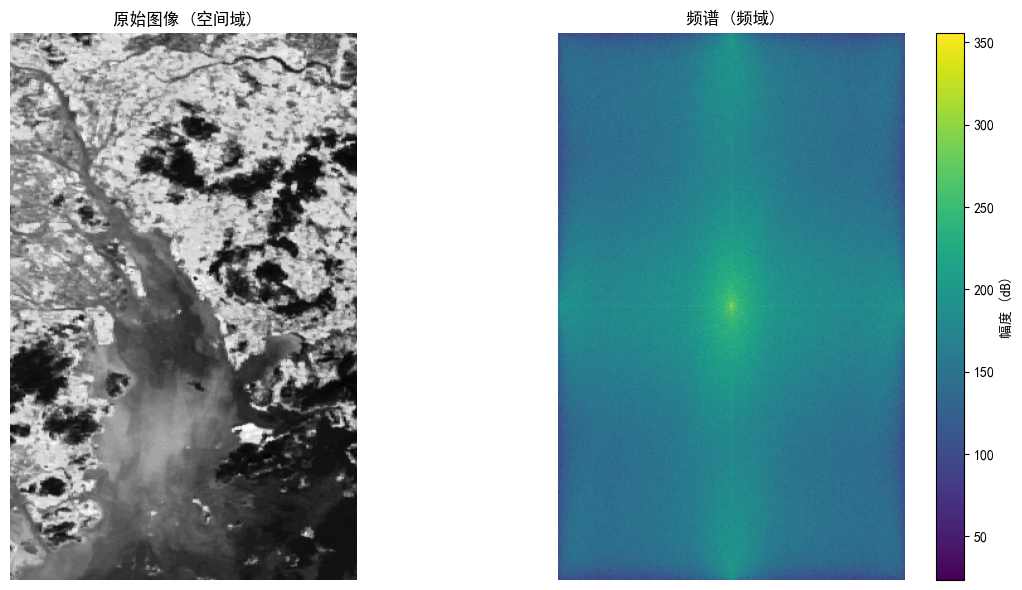

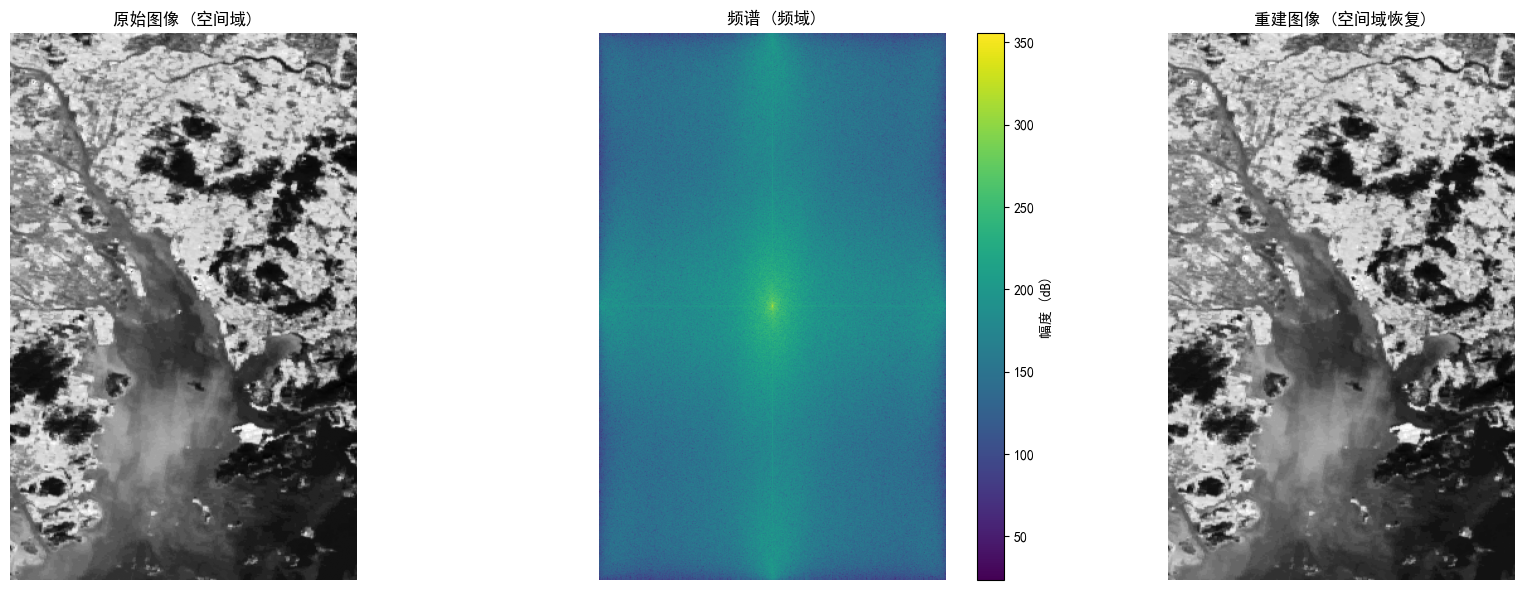

原始图像和重建图像的最大差异: 1.0
原始图像和重建图像的平均差异: 0.4712448754122121


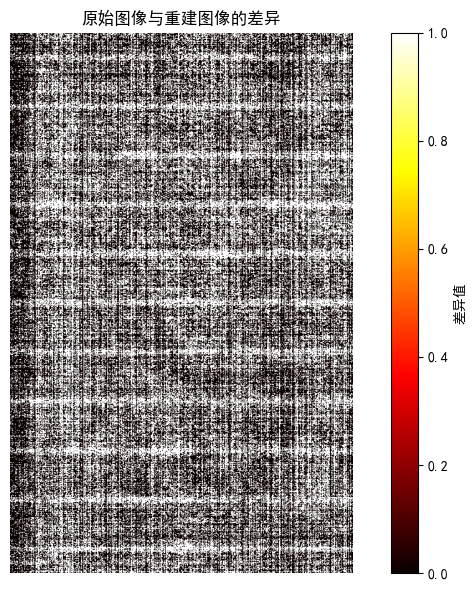

完成了完整的转换周期: 空间域 -> 频域 -> 空间域恢复。


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cv2
import matplotlib as mpl

# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'SimSun', 'Arial Unicode MS']  # 优先使用的中文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

def spatial_to_frequency_domain(image_path):
    # 读取图像
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        raise FileNotFoundError(f"无法加载图像: {image_path}")
    
    # 应用快速傅里叶变换 (FFT)
    f_transform = np.fft.fft2(img)
    
    # 将零频率分量移到中心
    f_transform_shifted = np.fft.fftshift(f_transform)
    
    # 计算频谱幅度 (取对数以便更好地可视化)
    magnitude_spectrum = 20 * np.log(np.abs(f_transform_shifted) + 1)
    
    # 可视化
    plt.figure(figsize=(12, 6))
    
    # 显示原始图像
    plt.subplot(121)
    plt.imshow(img, cmap='gray')
    plt.title('原始图像 (空间域)')
    plt.axis('off')
    
    # 显示频谱
    plt.subplot(122)
    plt.imshow(magnitude_spectrum, cmap='viridis')
    plt.title('频谱 (频域)')
    plt.colorbar(label='幅度 (dB)')
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('frequency_domain_transform.png', dpi=300)
    plt.show()
    
    return img, f_transform_shifted, magnitude_spectrum

def frequency_to_spatial_domain(f_transform_shifted):
    """
    将频域图像转换回空间域
    
    参数:
    f_transform_shifted: 频域中的图像（FFT后且经过fftshift的）
    
    返回:
    reconstructed_img: 重建的空间域图像
    """
    # 将频域图像逆向移位（将中心频率移回原位）
    f_transform = np.fft.ifftshift(f_transform_shifted)
    
    # 应用逆傅里叶变换
    reconstructed_complex = np.fft.ifft2(f_transform)
    
    # 取实部得到空间域图像（由于数值计算的小误差，可能会有微小的虚部）
    reconstructed_img = np.abs(reconstructed_complex).astype(np.uint8)
    
    return reconstructed_img

def complete_transformation_cycle(image_path):
    """
    展示完整的转换周期: 空间域 -> 频域 -> 空间域恢复
    """
    # 空间域 -> 频域
    original_img, f_transform_shifted, magnitude_spectrum = spatial_to_frequency_domain(image_path)
    
    # 频域 -> 空间域（重建）
    reconstructed_img = frequency_to_spatial_domain(f_transform_shifted)
    
    # 可视化完整转换过程
    plt.figure(figsize=(18, 6))
    
    # 显示原始图像
    plt.subplot(131)
    plt.imshow(original_img, cmap='gray')
    plt.title('原始图像 (空间域)')
    plt.axis('off')
    
    # 显示频域表示
    plt.subplot(132)
    plt.imshow(magnitude_spectrum, cmap='viridis')
    plt.title('频谱 (频域)')
    plt.colorbar(label='幅度 (dB)')
    plt.axis('off')
    
    # 显示重建图像
    plt.subplot(133)
    plt.imshow(reconstructed_img, cmap='gray')
    plt.title('重建图像 (空间域恢复)')
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('complete_transformation_cycle.png', dpi=300)
    plt.show()
    
    # 计算原始图像和重建图像之间的差异（以确认转换的准确性）
    diff = np.abs(original_img.astype(float) - reconstructed_img.astype(float))
    
    print(f"原始图像和重建图像的最大差异: {np.max(diff)}")
    print(f"原始图像和重建图像的平均差异: {np.mean(diff)}")
    
    # 显示差异图像（通常应该非常小）
    if np.max(diff) > 0.1:  # 只有当有显著差异时才显示
        plt.figure(figsize=(8, 6))
        plt.imshow(diff, cmap='hot')
        plt.colorbar(label='差异值')
        plt.title('原始图像与重建图像的差异')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

# 执行完整转换周期
image_path = "jet_pseudocolor_frames/pseudo_color_000.png"
try:
    complete_transformation_cycle(image_path)
    print("完成了完整的转换周期: 空间域 -> 频域 -> 空间域恢复。")
except Exception as e:
    print(f"错误: {e}")
    
# 频域滤波演示函数
def frequency_domain_filtering(image_path, filter_type='lowpass', cutoff_frequency=30):
    """
    在频域应用滤波器，然后转换回空间域
    
    参数:
    image_path: 图像路径
    filter_type: 滤波器类型，'lowpass'、'highpass' 或 'bandpass'
    cutoff_frequency: 截止频率（低通/高通）或内径（带通）
    
    返回:
    filtered_img: 滤波后的图像
    """
    # 读取图像
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        raise FileNotFoundError(f"无法加载图像: {image_path}")
    
    rows, cols = img.shape
    crow, ccol = rows // 2, cols // 2  # 中心点
    
    # 应用FFT
    f_transform = np.fft.fft2(img)
    f_transform_shifted = np.fft.fftshift(f_transform)
    
    # 创建滤波器蒙版
    mask = np.ones((rows, cols), np.uint8)
    
    if filter_type == 'lowpass':
        # 低通滤波（保留中心低频部分）
        cv2.circle(mask, (ccol, crow), cutoff_frequency, 1, -1)
        mask = mask.astype(bool)
    elif filter_type == 'highpass':
        # 高通滤波（移除中心低频部分）
        cv2.circle(mask, (ccol, crow), cutoff_frequency, 0, -1)
        mask = mask.astype(bool)
    elif filter_type == 'bandpass':
        # 带通滤波（保留中间频率环）
        outer_radius = cutoff_frequency * 2
        cv2.circle(mask, (ccol, crow), outer_radius, 1, -1)
        cv2.circle(mask, (ccol, crow), cutoff_frequency, 0, -1)
        mask = mask.astype(bool)
    
    # 应用滤波器
    f_transform_filtered = f_transform_shifted * mask
    
    # 逆变换
    f_inverse_shift = np.fft.ifftshift(f_transform_filtered)
    img_filtered_complex = np.fft.ifft2(f_inverse_shift)
    img_filtered = np.abs(img_filtered_complex).astype(np.uint8)
    
    # 计算频谱幅度（用于可视化）
    original_magnitude = 20 * np.log(np.abs(f_transform_shifted) + 1)
    filtered_magnitude = 20 * np.log(np.abs(f_transform_filtered) + 1)
    
    # 可视化
    plt.figure(figsize=(16, 10))
    
    # 原始图像
    plt.subplot(231)
    plt.imshow(img, cmap='gray')
    plt.title('原始图像')
    plt.axis('off')
    
    # 原始频谱
    plt.subplot(232)
    plt.imshow(original_magnitude, cmap='viridis')
    plt.title('原始频谱')
    plt.axis('off')
    
    # 滤波器蒙版
    plt.subplot(233)
    plt.imshow(mask, cmap='gray')
    plt.title(f'{filter_type} 滤波器')
    plt.axis('off')
    
    # 滤波后频谱
    plt.subplot(235)
    plt.imshow(filtered_magnitude, cmap='viridis')
    plt.title('滤波后频谱')
    plt.axis('off')
    
    # 滤波后图像
    plt.subplot(236)
    plt.imshow(img_filtered, cmap='gray')
    plt.title('滤波后图像')
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(f'{filter_type}_filtering.png', dpi=300)
    plt.show()
    
    return img_filtered

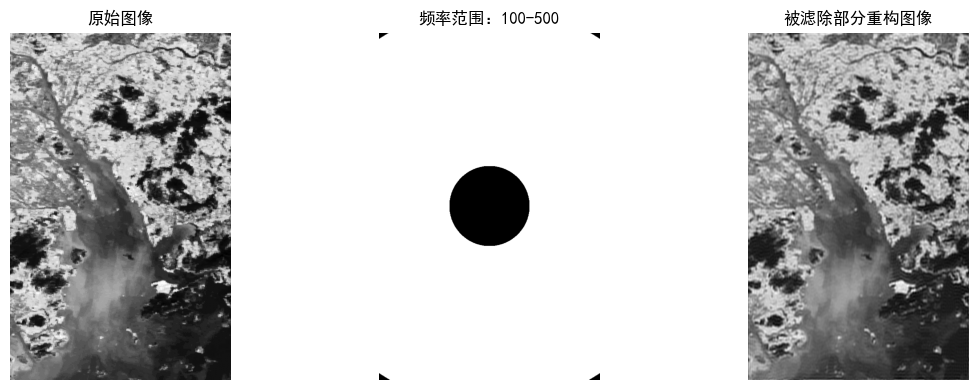

In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'SimSun', 'Arial Unicode MS']  # 优先使用的中文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

def filter_frequency_range(image_path, f_low, f_high):
    # 读取灰度图
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    rows, cols = img.shape
    crow, ccol = rows // 2, cols // 2

    # 傅里叶变换 + 移频
    f = np.fft.fft2(img)
    f_shifted = np.fft.fftshift(f)

    # 构造带通掩码
    y, x = np.ogrid[:rows, :cols]
    distance = np.sqrt((x - ccol)**2 + (y - crow)**2)
    mask = (distance >= f_low) & (distance <= f_high)

    # 提取被滤除部分（即掩码之外的频率）
    removed_part = f_shifted * (~mask)

    # 反变换得到图像中被滤掉的部分（例如低频或高频结构）
    removed_img = np.abs(np.fft.ifft2(np.fft.ifftshift(removed_part)))

    # 显示结果
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title('原始图像')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title(f'频率范围：{f_low}-{f_high}')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(removed_img, cmap='gray')
    plt.title('被滤除部分重构图像')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    return distance,f_shifted
# 使用示例：滤除低频 (0-30)，只看低频结构
distance,f_shifted=filter_frequency_range("jet_pseudocolor_frames/pseudo_color_000.png", f_low=100, f_high=500)


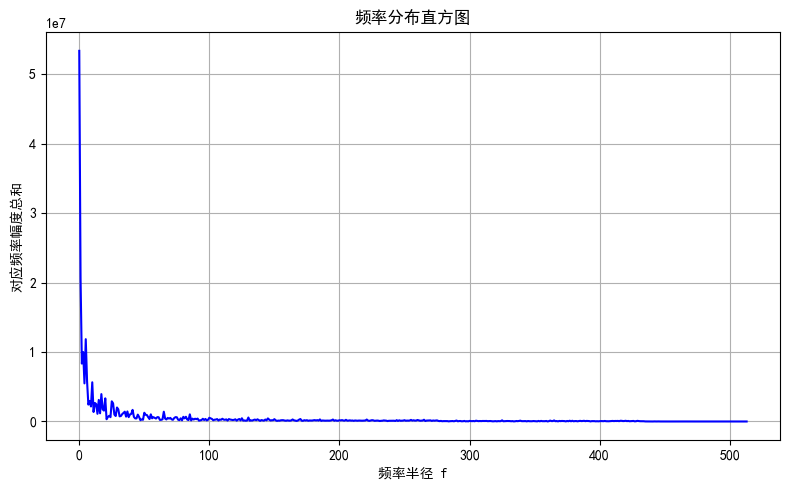

In [9]:
max_radius = int(distance.max())
hist = np.zeros(max_radius + 1)
magnitude = np.abs(f_shifted)
# 累加每个频率半径的幅度
for r in range(max_radius + 1):
    hist[r] = magnitude[distance == r].sum()

# 绘图
plt.figure(figsize=(8, 5))
plt.plot(np.arange(max_radius + 1), hist, color='blue')
plt.xlabel("频率半径 f")
plt.ylabel("对应频率幅度总和")
plt.title("频率分布直方图")
plt.grid(True)
plt.tight_layout()
plt.show()

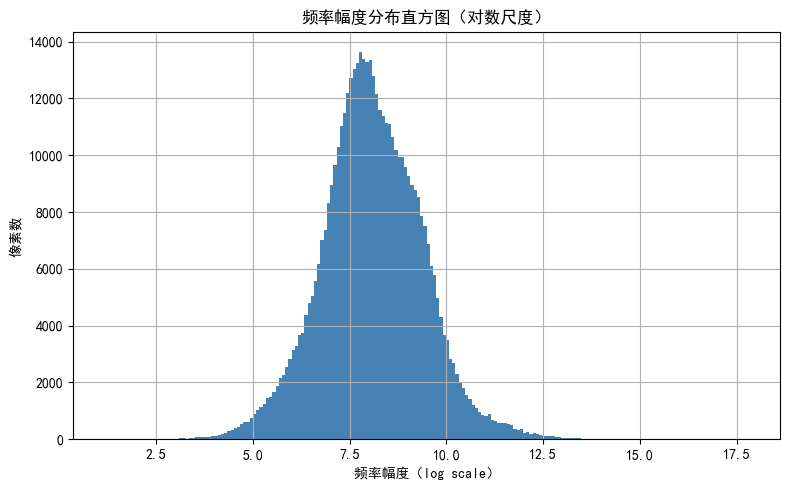

In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def plot_frequency_magnitude_histogram(image_path):
    # 读取图像并转换为灰度图
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError("图像路径无效")

    # 傅里叶变换 + 中心化
    f_transform = np.fft.fft2(img)
    f_shifted = np.fft.fftshift(f_transform)

    # 获取频率幅度谱
    magnitude = np.abs(f_shifted)

    # 展平为一维数组（去除中心亮点前可以裁剪或对数变换）
    magnitude_flat = magnitude.flatten()

    # 可选：对数变换以增强可视化
    magnitude_log = np.log1p(magnitude_flat)

    # 绘制频率幅度直方图（对数尺度更直观）
    plt.figure(figsize=(8, 5))
    plt.hist(magnitude_log, bins=200, color='steelblue')
    plt.title("频率幅度分布直方图（对数尺度）")
    plt.xlabel("频率幅度（log scale）")
    plt.ylabel("像素数")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 使用示例
plot_frequency_magnitude_histogram("jet_pseudocolor_frames/pseudo_color_000.png")


### 带通滤波频率分离

In [3]:
import os
import numpy as np
import cv2
from numpy.fft import fft2, ifft2, fftshift, ifftshift

# 输入输出路径
input_dir = "jet_pseudocolor_frames"
output_dirs = {
    'low': "FFT/low_freq",
    'mid': "FFT/mid_freq",
    'high': "FFT/high_freq"
}

# 创建输出目录
for d in output_dirs.values():
    os.makedirs(d, exist_ok=True)

# 带通滤波器构造
def make_bandpass_mask(shape, f_low, f_high):
    h, w = shape
    cy, cx = h // 2, w // 2
    Y, X = np.ogrid[:h, :w]
    distance = np.sqrt((X - cx)**2 + (Y - cy)**2)
    mask = np.logical_and(distance >= f_low, distance <= f_high).astype(np.float32)
    return mask

# 滤波器参数（单位：像素半径）
low_cutoff = 0
mid_cutoff1, mid_cutoff2 = 30, 60
high_cutoff = 60

# 主循环：处理每张图
for filename in os.listdir(input_dir):
    if not filename.lower().endswith(".png"):
        continue  # 跳过非 PNG 文件
    path = os.path.join(input_dir, filename)
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    # 傅里叶变换
    f = fft2(img)
    fshift = fftshift(f)
    magnitude = np.abs(fshift)
    phase = np.angle(fshift)

    # 频段掩码
    low_mask = make_bandpass_mask(img.shape, 0, mid_cutoff1)
    mid_mask = make_bandpass_mask(img.shape, mid_cutoff1, mid_cutoff2)
    high_mask = make_bandpass_mask(img.shape, high_cutoff, min(img.shape)//2)

    # 分离频段 + 反变换
    for band, mask in zip(['low', 'mid', 'high'], [low_mask, mid_mask, high_mask]):
        filtered = fshift * mask
        img_back = np.abs(ifft2(ifftshift(filtered)))
        img_back = np.clip(img_back, 0, 255).astype(np.uint8)
        save_path = os.path.join(output_dirs[band], filename)
        cv2.imwrite(save_path, img_back)


### 低通滤波频率分离

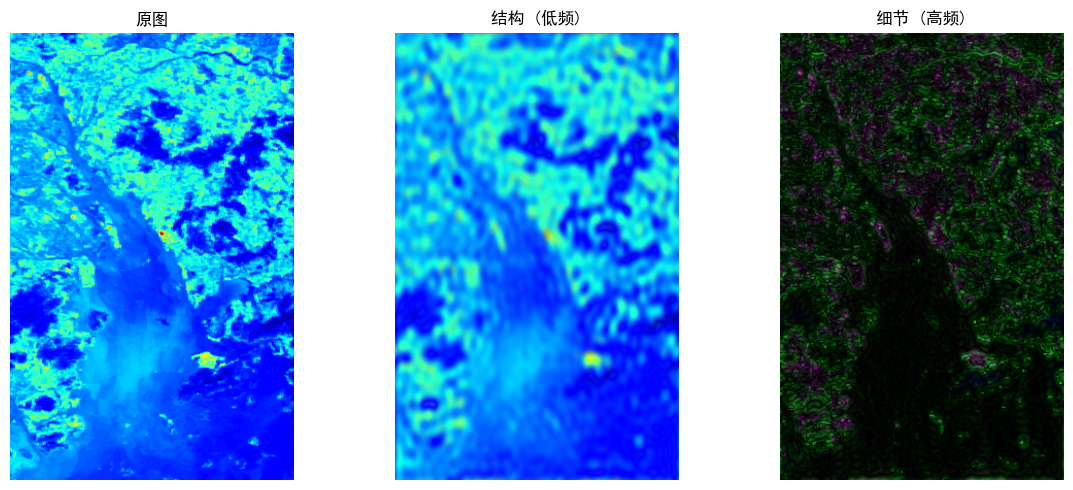

In [5]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'SimSun', 'Arial Unicode MS']  # 优先使用的中文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
def fft_filter_channel(channel, cutoff, size):
    # FFT + shift
    f = np.fft.fft2(channel)
    fshift = np.fft.fftshift(f)

    rows, cols = size
    crow, ccol = rows // 2, cols // 2

    # 创建低通掩码
    lowpass_mask = np.zeros((rows, cols), np.uint8)
    cv2.circle(lowpass_mask, (ccol, crow), cutoff, 1, -1)
    highpass_mask = 1 - lowpass_mask

    # 应用低通和高通滤波
    f_low = fshift * lowpass_mask
    f_high = fshift * highpass_mask

    # 逆傅里叶变换
    img_low = np.fft.ifft2(np.fft.ifftshift(f_low))
    img_high = np.fft.ifft2(np.fft.ifftshift(f_high))

    return np.abs(img_low), np.abs(img_high)

def split_structure_detail_rgb(image_path, cutoff=30):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img_rgb.shape

    channels = cv2.split(img_rgb)
    low_parts, high_parts = [], []

    for c in channels:
        low, high = fft_filter_channel(c, cutoff, (h, w))
        low_parts.append(low)
        high_parts.append(high)

    structure = cv2.merge([np.clip(x, 0, 255).astype(np.uint8) for x in low_parts])
    detail = cv2.merge([np.clip(x, 0, 255).astype(np.uint8) for x in high_parts])

    return structure, detail

# 示例执行
input_image = "jet_pseudocolor_frames/pseudo_color_000.png"
structure_img, detail_img = split_structure_detail_rgb(input_image, cutoff=30)

# 保存结果
cv2.imwrite("structure.png", cv2.cvtColor(structure_img, cv2.COLOR_RGB2BGR))
cv2.imwrite("detail.png", cv2.cvtColor(detail_img, cv2.COLOR_RGB2BGR))

# 可视化
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(cv2.imread(input_image), cv2.COLOR_BGR2RGB))
plt.title("原图")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(structure_img)
plt.title("结构 (低频)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(detail_img)
plt.title("细节 (高频)")
plt.axis('off')
plt.tight_layout()
plt.show()


### 时序一致性检测

开始时序插补与稳定性分析

1. 加载图像序列...
找到 8 个图像文件
图像序列形状: (8, 2170, 1376, 3)

2. 检测缺失帧...
检测到 0 个缺失/异常帧

3. 分析时序稳定性...
计算周期性指标...
增强热力图已保存到: STAT_results\enhanced_stability_heatmap.png

保存单独热力图:
已保存: STAT_results\temporal_variance.png
已保存: STAT_results\coefficient_variation.png
已保存: STAT_results\relative_change.png
已保存: STAT_results\trend_stability.png
已保存: STAT_results\periodicity.png
已保存: STAT_results\periodicity_regularity.png
已保存: STAT_results\stability_score.png
已保存: STAT_results\stability_classes.png
已保存: STAT_results\component_weights.png


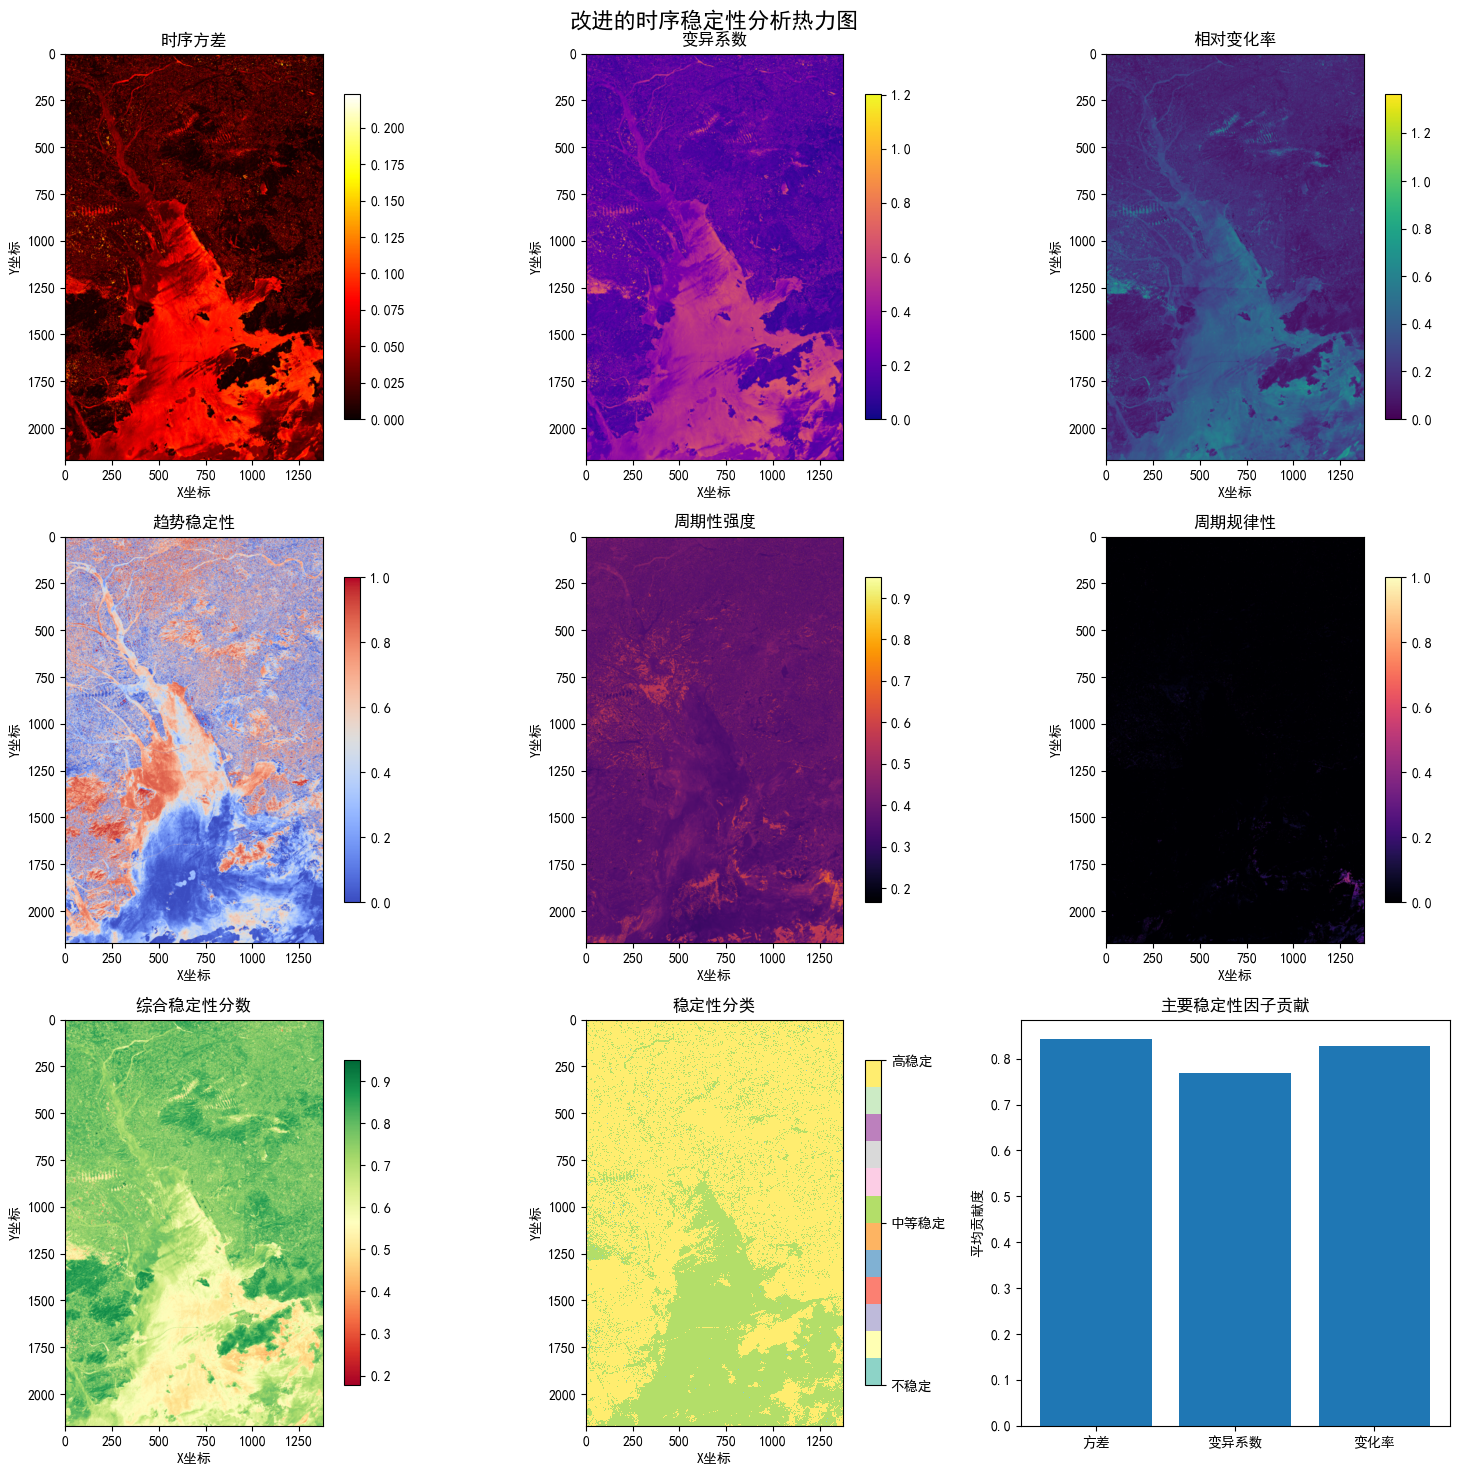


时序稳定性分析报告

整体稳定性统计:
  平均稳定性分数: 0.719
  稳定性标准差: 0.108
  最高稳定性: 0.951
  最低稳定性: 0.177

稳定性分类分布:
  高稳定区域: 64.9%
  中等稳定区域: 35.0%
  不稳定区域: 0.1%

各稳定性因子平均得分:
  方差稳定性: 0.843
  变异系数稳定性: 0.769
  变化率稳定性: 0.828
  趋势稳定性: 0.417
  周期稳定性: 0.567

周期性分析:
  平均周期性强度: 0.387
  强周期性区域比例: 6.8%
  平均周期规律性: 0.004

4. 执行时序插补...
没有检测到缺失帧，使用原始图像

5. 保存结果...



✅ 处理完成！结果保存在: STAT_results
   - 稳定性热力图: STAT_results\enhanced_stability_heatmap.png
   - 插补结果: STAT_results/interpolated_*.png
   - 对比图: STAT_results/interpolation_comparison.png


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.signal import find_peaks
import re
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'SimSun', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

class TimeSeriesStabilityAnalyzer:
    """改进的时序稳定性分析器"""
    
    def __init__(self):
        pass
    
    def calculate_improved_periodicity(self, pixel_ts):
        """改进的周期性检测方法"""
        if len(pixel_ts) < 4:
            return 0, 0
        
        # 方法1: 自相关函数法
        def autocorr_periodicity(ts):
            # 计算自相关函数
            autocorr = np.correlate(ts, ts, mode='full')
            autocorr = autocorr[len(autocorr)//2:]
            
            if len(autocorr) == 0 or autocorr[0] == 0:
                return 0
                
            autocorr = autocorr / autocorr[0]  # 归一化
            
            # 寻找除0点外的最大自相关值
            if len(autocorr) > 1:
                max_autocorr = np.max(autocorr[1:len(autocorr)//2])
                return max_autocorr
            return 0
        
        # 方法2: 频谱熵法
        def spectral_entropy_periodicity(ts):
            fft_result = np.fft.fft(ts)
            power_spectrum = np.abs(fft_result[1:len(fft_result)//2])
            
            if len(power_spectrum) == 0 or np.sum(power_spectrum) < 1e-8:
                return 0
                
            # 归一化功率谱
            power_spectrum = power_spectrum / np.sum(power_spectrum)
            
            # 计算谱熵 (低熵表示周期性强)
            entropy = -np.sum(power_spectrum * np.log(power_spectrum + 1e-12))
            max_entropy = np.log(len(power_spectrum))
            
            if max_entropy == 0:
                return 0
            
            # 周期性 = 1 - 归一化熵
            return 1 - entropy / max_entropy
        
        # 方法3: 峰值检测法
        def peak_detection_periodicity(ts):
            try:
                # 标准化时间序列
                ts_std = np.std(ts)
                if ts_std < 1e-8:
                    return 0
                    
                ts_norm = (ts - np.mean(ts)) / ts_std
                
                # 检测峰值
                peaks, _ = find_peaks(ts_norm, height=0.5, distance=max(1, len(ts)//10))
                
                if len(peaks) < 2:
                    return 0
                    
                # 计算峰值间距的一致性
                intervals = np.diff(peaks)
                if len(intervals) < 2:
                    return 0
                    
                # 间距一致性作为周期性指标
                interval_std = np.std(intervals)
                interval_mean = np.mean(intervals)
                
                if interval_mean < 1e-8:
                    return 0
                    
                consistency = 1 / (1 + interval_std / interval_mean)
                return consistency
            except Exception:
                return 0
        
        # 综合三种方法
        autocorr_score = autocorr_periodicity(pixel_ts)
        entropy_score = spectral_entropy_periodicity(pixel_ts)
        peak_score = peak_detection_periodicity(pixel_ts)
        
        # 加权平均
        periodicity_score = 0.4 * autocorr_score + 0.4 * entropy_score + 0.2 * peak_score
        
        # 周期规律性评估
        regularity_score = min(entropy_score, peak_score)  # 保守估计
        
        return periodicity_score, regularity_score
    
    def calculate_stability_metrics(self, time_series_data):
        """
        改进的时序稳定性指标计算
        time_series_data: [T, H, W, C] - 时间序列数据
        返回详细的稳定性指标
        """
        T, H, W, C = time_series_data.shape
        
        # 1. 基础统计指标
        temporal_variance = np.var(time_series_data, axis=0).mean(axis=-1)  # [H, W]
        temporal_std = np.std(time_series_data, axis=0).mean(axis=-1)  # [H, W]
        temporal_mean = np.mean(time_series_data, axis=0).mean(axis=-1)  # [H, W]
        
        # 变异系数 (相对稳定性)
        cv = temporal_std / (temporal_mean + 1e-8)
        
        # 2. 变化率指标
        temporal_diff = np.diff(time_series_data, axis=0)  # [T-1, H, W, C]
        change_rate = np.mean(np.abs(temporal_diff), axis=(0, -1))  # [H, W]
        
        # 相对变化率
        relative_change = change_rate / (temporal_mean + 1e-8)
        
        # 3. 趋势稳定性
        trend_stability = np.zeros((H, W))
        for i in range(H):
            for j in range(W):
                pixel_ts = time_series_data[:, i, j, :].mean(axis=1)
                
                # 计算趋势的线性度
                if len(pixel_ts) > 2:
                    x = np.arange(len(pixel_ts))
                    try:
                        # 线性回归
                        coeffs = np.polyfit(x, pixel_ts, 1)
                        predicted = np.polyval(coeffs, x)
                        
                        # 计算R²
                        ss_res = np.sum((pixel_ts - predicted) ** 2)
                        ss_tot = np.sum((pixel_ts - np.mean(pixel_ts)) ** 2)
                        
                        if ss_tot > 1e-8:
                            r_squared = 1 - (ss_res / ss_tot)
                            trend_stability[i, j] = max(0, r_squared)
                        else:
                            trend_stability[i, j] = 1.0  # 完全平稳
                    except Exception:
                        trend_stability[i, j] = 0
        
        # 4. 改进的周期性检测
        periodicity_map = np.zeros((H, W))
        periodicity_regularity = np.zeros((H, W))
        
        print("计算周期性指标...")
        for i in range(H):
            for j in range(W):
                pixel_ts = time_series_data[:, i, j, :].mean(axis=1)
                
                # 使用改进的周期性检测
                periodicity_score, regularity_score = self.calculate_improved_periodicity(pixel_ts)
                periodicity_map[i, j] = periodicity_score
                periodicity_regularity[i, j] = regularity_score
        
        # 5. 综合稳定性评分 - 重新设计权重逻辑
        def safe_normalize(metric):
            """安全的归一化函数"""
            min_val, max_val = np.min(metric), np.max(metric)
            if max_val - min_val < 1e-8:
                return np.ones_like(metric) * 0.5  # 如果没有变化，返回中等值
            return (metric - min_val) / (max_val - min_val)
        
        # 归一化各指标 (注意方向性)
        variance_stability = 1 - safe_normalize(temporal_variance)  # 低方差 = 高稳定
        cv_stability = 1 - safe_normalize(cv)  # 低变异系数 = 高稳定
        change_stability = 1 - safe_normalize(relative_change)  # 低变化率 = 高稳定
        trend_stability_norm = safe_normalize(trend_stability)  # 高R² = 高稳定
        
        # 周期性的处理 - 区分规律周期和混乱变化
        period_stability = np.zeros_like(periodicity_map)
        
        # 使用分位数而不是固定阈值
        variance_75th = np.percentile(temporal_variance, 75)
        
        for i in range(H):
            for j in range(W):
                period_score = periodicity_map[i, j]
                regularity_score = periodicity_regularity[i, j]
                variance_val = temporal_variance[i, j]
                
                if period_score > 0.5:  # 强周期性
                    if variance_val > variance_75th:
                        # 强周期性但振幅大 - 中等稳定性
                        period_stability[i, j] = 0.6 + 0.2 * regularity_score
                    else:
                        # 强周期性且振幅小 - 高稳定性
                        period_stability[i, j] = 0.8 + 0.2 * regularity_score
                elif period_score > 0.2:  # 中等周期性
                    # 主要看方差和规律性
                    period_stability[i, j] = 0.3 + 0.4 * regularity_score + 0.3 * variance_stability[i, j]
                else:  # 弱周期性
                    # 主要看方差稳定性
                    period_stability[i, j] = variance_stability[i, j]
        
        # 6. 加权综合评分
        weights = {
            'variance': 0.25,     # 基础稳定性
            'cv': 0.20,          # 相对稳定性  
            'change': 0.25,      # 变化稳定性
            'trend': 0.15,       # 趋势稳定性
            'period': 0.15       # 周期稳定性
        }
        
        stability_score = (
            weights['variance'] * variance_stability +
            weights['cv'] * cv_stability +
            weights['change'] * change_stability +
            weights['trend'] * trend_stability_norm +
            weights['period'] * period_stability
        )
        
        return {
            # 原始指标
            'temporal_variance': temporal_variance,
            'coefficient_variation': cv,
            'change_rate': change_rate,
            'relative_change': relative_change,
            'trend_stability': trend_stability,
            'periodicity': periodicity_map,
            'periodicity_regularity': periodicity_regularity,
            
            # 综合指标
            'stability_score': stability_score,
            
            # 分量得分
            'component_scores': {
                'variance_stability': variance_stability,
                'cv_stability': cv_stability,
                'change_stability': change_stability,
                'trend_stability': trend_stability_norm,
                'period_stability': period_stability
            }
        }
    
    def generate_enhanced_heatmaps(self, stability_metrics, save_path=None):
        """生成增强的稳定性热力图，并将每个子图单独保存"""
        fig, axes = plt.subplots(3, 3, figsize=(15, 15))
        fig.suptitle('改进的时序稳定性分析热力图', fontsize=16)
        
        # 定义每个子图的标题和文件名
        subplot_info = [
            {'title': '时序方差', 'filename': 'temporal_variance.png', 'cmap': 'hot'},
            {'title': '变异系数', 'filename': 'coefficient_variation.png', 'cmap': 'plasma'},
            {'title': '相对变化率', 'filename': 'relative_change.png', 'cmap': 'viridis'},
            {'title': '趋势稳定性', 'filename': 'trend_stability.png', 'cmap': 'coolwarm'},
            {'title': '周期性强度', 'filename': 'periodicity.png', 'cmap': 'inferno'},
            {'title': '周期规律性', 'filename': 'periodicity_regularity.png', 'cmap': 'magma'},
            {'title': '综合稳定性分数', 'filename': 'stability_score.png', 'cmap': 'RdYlGn'},
            {'title': '稳定性分类', 'filename': 'stability_classes.png', 'cmap': 'Set3'},
            {'title': '主要稳定性因子贡献', 'filename': 'component_weights.png', 'type': 'bar'}
        ]
        
        # 保存目录
        save_dir = Path(save_path).parent if save_path else Path("./heatmaps")
        save_dir.mkdir(exist_ok=True)
        
        # 第一行: 基础指标
        im1 = axes[0, 0].imshow(stability_metrics['temporal_variance'], cmap=subplot_info[0]['cmap'], interpolation='bilinear')
        axes[0, 0].set_title(subplot_info[0]['title'])
        plt.colorbar(im1, ax=axes[0, 0], shrink=0.8)
        
        im2 = axes[0, 1].imshow(stability_metrics['coefficient_variation'], cmap=subplot_info[1]['cmap'], interpolation='bilinear')
        axes[0, 1].set_title(subplot_info[1]['title'])
        plt.colorbar(im2, ax=axes[0, 1], shrink=0.8)
        
        im3 = axes[0, 2].imshow(stability_metrics['relative_change'], cmap=subplot_info[2]['cmap'], interpolation='bilinear')
        axes[0, 2].set_title(subplot_info[2]['title'])
        plt.colorbar(im3, ax=axes[0, 2], shrink=0.8)
        
        # 第二行: 高级指标
        im4 = axes[1, 0].imshow(stability_metrics['trend_stability'], cmap=subplot_info[3]['cmap'], interpolation='bilinear')
        axes[1, 0].set_title(subplot_info[3]['title'])
        plt.colorbar(im4, ax=axes[1, 0], shrink=0.8)
        
        im5 = axes[1, 1].imshow(stability_metrics['periodicity'], cmap=subplot_info[4]['cmap'], interpolation='bilinear')
        axes[1, 1].set_title(subplot_info[4]['title'])
        plt.colorbar(im5, ax=axes[1, 1], shrink=0.8)
        
        im6 = axes[1, 2].imshow(stability_metrics['periodicity_regularity'], cmap=subplot_info[5]['cmap'], interpolation='bilinear')
        axes[1, 2].set_title(subplot_info[5]['title'])
        plt.colorbar(im6, ax=axes[1, 2], shrink=0.8)
        
        # 第三行: 综合指标
        im7 = axes[2, 0].imshow(stability_metrics['stability_score'], cmap=subplot_info[6]['cmap'], interpolation='bilinear')
        axes[2, 0].set_title(subplot_info[6]['title'])
        plt.colorbar(im7, ax=axes[2, 0], shrink=0.8)
        
        # 稳定性分类图
        stability_classes = self.classify_stability(stability_metrics['stability_score'])
        im8 = axes[2, 1].imshow(stability_classes, cmap=subplot_info[7]['cmap'], interpolation='nearest')
        axes[2, 1].set_title(subplot_info[7]['title'])
        cbar8 = plt.colorbar(im8, ax=axes[2, 1], shrink=0.8)
        cbar8.set_ticks([0, 1, 2])
        cbar8.set_ticklabels(['不稳定', '中等稳定', '高稳定'])
        
        # 权重贡献图
        component_weights = np.array([stability_metrics['component_scores']['variance_stability'],
                                    stability_metrics['component_scores']['cv_stability'],
                                    stability_metrics['component_scores']['change_stability']]).mean(axis=(1,2))
        
        axes[2, 2].bar(['方差', '变异系数', '变化率'], component_weights[:3])
        axes[2, 2].set_title(subplot_info[8]['title'])
        axes[2, 2].set_ylabel('平均贡献度')
        
        # 设置坐标轴标签
        for i in range(3):
            for j in range(3):
                if i < 2 or j < 2:  # 排除最后一个柱状图
                    axes[i, j].set_xlabel('X坐标')
                    axes[i, j].set_ylabel('Y坐标')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"增强热力图已保存到: {save_path}")
        
        # 保存每个子图单独图片
        print("\n保存单独热力图:")
        for i, info in enumerate(subplot_info):
            plt.figure(figsize=(6, 5))
            
            if i < 7:  # 前7个是热力图
                if i < 6:
                    data = list(stability_metrics.values())[i]
                else:
                    data = stability_metrics['stability_score']
                
                plt.imshow(data, cmap=info['cmap'], interpolation='bilinear')
                plt.title(info['title'])
                plt.colorbar(shrink=0.8)
                plt.xlabel('X坐标')
                plt.ylabel('Y坐标')
                
            elif i == 7:  # 稳定性分类图
                plt.imshow(stability_classes, cmap=info['cmap'], interpolation='nearest')
                plt.title(info['title'])
                cbar = plt.colorbar(shrink=0.8)
                cbar.set_ticks([0, 1, 2])
                cbar.set_ticklabels(['不稳定', '中等稳定', '高稳定'])
                plt.xlabel('X坐标')
                plt.ylabel('Y坐标')
                
            else:  # 柱状图
                plt.bar(['方差', '变异系数', '变化率'], component_weights[:3])
                plt.title(info['title'])
                plt.ylabel('平均贡献度')
            
            save_file = save_dir / info['filename']
            plt.tight_layout()
            plt.savefig(save_file, dpi=300, bbox_inches='tight')
            plt.close()
            print(f"已保存: {save_file}")
        
        plt.show()
        return fig
    
    def classify_stability(self, stability_score):
        """将稳定性分数分类"""
        classes = np.zeros_like(stability_score)
        classes[stability_score < 0.4] = 0  # 不稳定
        classes[(stability_score >= 0.4) & (stability_score < 0.7)] = 1  # 中等稳定
        classes[stability_score >= 0.7] = 2  # 高稳定
        return classes
    
    def generate_stability_report(self, stability_metrics):
        """生成稳定性分析报告"""
        print("\n" + "="*60)
        print("时序稳定性分析报告")
        print("="*60)
        
        stability_score = stability_metrics['stability_score']
        
        # 整体统计
        print(f"\n整体稳定性统计:")
        print(f"  平均稳定性分数: {np.mean(stability_score):.3f}")
        print(f"  稳定性标准差: {np.std(stability_score):.3f}")
        print(f"  最高稳定性: {np.max(stability_score):.3f}")
        print(f"  最低稳定性: {np.min(stability_score):.3f}")
        
        # 稳定性分类统计
        classes = self.classify_stability(stability_score)
        total_pixels = classes.size
        unstable_ratio = np.sum(classes == 0) / total_pixels
        moderate_ratio = np.sum(classes == 1) / total_pixels
        stable_ratio = np.sum(classes == 2) / total_pixels
        
        print(f"\n稳定性分类分布:")
        print(f"  高稳定区域: {stable_ratio:.1%}")
        print(f"  中等稳定区域: {moderate_ratio:.1%}")
        print(f"  不稳定区域: {unstable_ratio:.1%}")
        
        # 各指标贡献分析
        components = stability_metrics['component_scores']
        print(f"\n各稳定性因子平均得分:")
        print(f"  方差稳定性: {np.mean(components['variance_stability']):.3f}")
        print(f"  变异系数稳定性: {np.mean(components['cv_stability']):.3f}")
        print(f"  变化率稳定性: {np.mean(components['change_stability']):.3f}")
        print(f"  趋势稳定性: {np.mean(components['trend_stability']):.3f}")
        print(f"  周期稳定性: {np.mean(components['period_stability']):.3f}")
        
        # 周期性分析
        periodicity = stability_metrics['periodicity']
        print(f"\n周期性分析:")
        print(f"  平均周期性强度: {np.mean(periodicity):.3f}")
        print(f"  强周期性区域比例: {np.sum(periodicity > 0.5) / periodicity.size:.1%}")
        print(f"  平均周期规律性: {np.mean(stability_metrics['periodicity_regularity']):.3f}")
        
        print("="*60)

# 其余类保持不变，只需要在 TimeSeriesInterpolator 中调用新的方法
class SimplifiedSTAT(nn.Module):
    """精简版时空注意力Transformer"""
    
    def __init__(self, input_channels=3, d_model=128, n_heads=4, n_layers=3):
        super().__init__()
        self.d_model = d_model
        self.input_channels = input_channels
        
        # 输入投影
        self.input_proj = nn.Conv2d(input_channels, d_model, 1)
        
        # 时间注意力
        self.temporal_attention = nn.MultiheadAttention(d_model, n_heads, batch_first=True)
        
        # 空间卷积
        self.spatial_conv = nn.Sequential(
            nn.Conv2d(d_model, d_model, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(d_model, d_model, 3, padding=1)
        )
        
        # 输出投影
        self.output_proj = nn.Conv2d(d_model, input_channels, 1)
        
        # 层归一化
        self.layer_norm = nn.LayerNorm(d_model)
        
    def forward(self, x):
        """
        x: [B, T, C, H, W] - 批次，时间，通道，高，宽
        """
        B, T, C, H, W = x.shape
        
        # 输入投影 [B*T, C, H, W] -> [B*T, d_model, H, W]
        x_reshaped = x.view(B*T, C, H, W)
        x_proj = self.input_proj(x_reshaped)  # [B*T, d_model, H, W]
        
        # 空间特征提取
        x_spatial = self.spatial_conv(x_proj)  # [B*T, d_model, H, W]
        x_spatial = x_spatial + x_proj  # 残差连接
        
        # 重塑为时序格式 [B, T, d_model, H, W] -> [B*H*W, T, d_model]
        x_temporal = x_spatial.view(B, T, self.d_model, H*W).permute(0, 3, 1, 2)  # [B, H*W, T, d_model]
        x_temporal = x_temporal.reshape(B*H*W, T, self.d_model)
        
        # 时间注意力
        x_attn, _ = self.temporal_attention(x_temporal, x_temporal, x_temporal)
        x_attn = self.layer_norm(x_attn + x_temporal)  # 残差 + 归一化
        
        # 重塑回空间格式
        x_out = x_attn.view(B, H*W, T, self.d_model).permute(0, 2, 3, 1)  # [B, T, d_model, H*W]
        x_out = x_out.reshape(B*T, self.d_model, H, W)
        
        # 输出投影
        output = self.output_proj(x_out)  # [B*T, C, H, W]
        output = output.view(B, T, C, H, W)
        
        return output

class TimeSeriesInterpolator:
    """时序插补器 - 主要处理类"""
    
    def __init__(self, data_dir, model_path=None):
        self.data_dir = Path(data_dir)
        self.model = SimplifiedSTAT()
        if model_path and os.path.exists(model_path):
            self.model.load_state_dict(torch.load(model_path))
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        
        self.analyzer = TimeSeriesStabilityAnalyzer()
        
    def load_image_sequence(self):
        """加载图像序列"""
        # 获取所有pseudo_color_xxx.png文件
        image_files = list(self.data_dir.glob("pseudo_color_*.png"))
        image_files.sort(key=lambda x: int(re.findall(r'pseudo_color_(\d+)\.png', x.name)[0]))
        
        print(f"找到 {len(image_files)} 个图像文件")
        
        if len(image_files) == 0:
            raise ValueError(f"在 {self.data_dir} 中没有找到 pseudo_color_*.png 文件")
        
        # 读取图像
        images = []
        for img_path in image_files:
            img = cv2.imread(str(img_path))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32) / 255.0  # 归一化到0-1
            images.append(img)
        
        images = np.stack(images, axis=0)  # [T, H, W, C]
        print(f"图像序列形状: {images.shape}")
        
        return images, [f.name for f in image_files]
    
    def detect_missing_frames(self, images, threshold=0.1):
        """检测缺失或质量差的帧"""
        T, H, W, C = images.shape
        missing_mask = np.ones(T, dtype=bool)  # True = 有效帧
        
        # 基于图像亮度检测异常帧
        brightness = np.mean(images, axis=(1, 2, 3))
        mean_brightness = np.mean(brightness)
        std_brightness = np.std(brightness)
        
        # 标记异常亮度的帧为缺失
        anomaly_threshold = 2 * std_brightness
        for t in range(T):
            if abs(brightness[t] - mean_brightness) > anomaly_threshold:
                missing_mask[t] = False
                print(f"检测到异常帧: {t}, 亮度: {brightness[t]:.3f}")
        
        return missing_mask
    
    def simple_interpolation(self, images, missing_mask):
        """简单插补方法 (用于对比)"""
        T, H, W, C = images.shape
        interpolated = images.copy()
        
        for t in range(T):
            if not missing_mask[t]:  # 如果是缺失帧
                # 寻找最近的有效帧
                prev_valid = None
                next_valid = None
                
                # 向前寻找
                for i in range(t-1, -1, -1):
                    if missing_mask[i]:
                        prev_valid = i
                        break
                
                # 向后寻找
                for i in range(t+1, T):
                    if missing_mask[i]:
                        next_valid = i
                        break
                
                # 线性插值
                if prev_valid is not None and next_valid is not None:
                    alpha = (t - prev_valid) / (next_valid - prev_valid)
                    interpolated[t] = (1 - alpha) * images[prev_valid] + alpha * images[next_valid]
                elif prev_valid is not None:
                    interpolated[t] = images[prev_valid]
                elif next_valid is not None:
                    interpolated[t] = images[next_valid]
        
        return interpolated
    
    def stat_interpolation(self, images, missing_mask):
        """使用STAT模型进行插补"""
        # 转换为torch张量
        images_tensor = torch.from_numpy(images).permute(0, 3, 1, 2).unsqueeze(0).float()  # [1, T, C, H, W]
        images_tensor = images_tensor.to(self.device)
        
        self.model.eval()
        with torch.no_grad():
            # STAT模型前向传播
            reconstructed = self.model(images_tensor)  # [1, T, C, H, W]
            reconstructed = reconstructed.squeeze(0).permute(0, 2, 3, 1).cpu().numpy()  # [T, H, W, C]
        
        # 只替换缺失帧
        result = images.copy()
        for t in range(len(missing_mask)):
            if not missing_mask[t]:
                result[t] = reconstructed[t]
        
        return result
    
    def process_and_analyze(self, save_dir="./results"):
        """主处理流程"""
        save_dir = Path(save_dir)
        save_dir.mkdir(exist_ok=True)
        
        print("=" * 50)
        print("开始时序插补与稳定性分析")
        print("=" * 50)
        
        # 1. 加载图像序列
        print("\n1. 加载图像序列...")
        images, filenames = self.load_image_sequence()
        T, H, W, C = images.shape
        
        # 2. 检测缺失帧
        print("\n2. 检测缺失帧...")
        missing_mask = self.detect_missing_frames(images)
        missing_count = np.sum(~missing_mask)
        print(f"检测到 {missing_count} 个缺失/异常帧")
        
        # 3. 稳定性分析
        print("\n3. 分析时序稳定性...")
        stability_metrics = self.analyzer.calculate_stability_metrics(images)
        
        # 生成增强的稳定性热力图
        heatmap_path = save_dir / "enhanced_stability_heatmap.png"
        self.analyzer.generate_enhanced_heatmaps(stability_metrics, heatmap_path)
        
        # 生成稳定性报告
        self.analyzer.generate_stability_report(stability_metrics)
        
        # 4. 时序插补
        print("\n4. 执行时序插补...")
        
        # 简单线性插补
        linear_result = self.simple_interpolation(images, missing_mask)
        
        # STAT插补 (如果有缺失帧)
        if missing_count > 0:
            print("使用STAT模型进行插补...")
            stat_result = self.stat_interpolation(images, missing_mask)
        else:
            print("没有检测到缺失帧，使用原始图像")
            stat_result = images
        
        # 5. 保存结果
        print("\n5. 保存结果...")
        
        # 保存插补后的图像
        for t in range(T):
            # 原始图像
            orig_img = (images[t] * 255).astype(np.uint8)
            cv2.imwrite(str(save_dir / f"original_{t:03d}.png"), 
                       cv2.cvtColor(orig_img, cv2.COLOR_RGB2BGR))
            
            # STAT插补结果
            stat_img = (stat_result[t] * 255).astype(np.uint8)
            cv2.imwrite(str(save_dir / f"interpolated_{t:03d}.png"), 
                       cv2.cvtColor(stat_img, cv2.COLOR_RGB2BGR))
        
        # 生成对比图
        self.create_comparison_figure(images, stat_result, missing_mask, 
                                    save_dir / "interpolation_comparison.png")
        
        # 保存稳定性数据
        np.savez(save_dir / "stability_metrics.npz", **stability_metrics)
        
        print(f"\n✅ 处理完成！结果保存在: {save_dir}")
        print(f"   - 稳定性热力图: {heatmap_path}")
        print(f"   - 插补结果: {save_dir}/interpolated_*.png")
        print(f"   - 对比图: {save_dir}/interpolation_comparison.png")
        
        return {
            'images': images,
            'interpolated': stat_result,
            'stability_metrics': stability_metrics,
            'missing_mask': missing_mask
        }
    
    def create_comparison_figure(self, original, interpolated, missing_mask, save_path):
        """创建插补前后对比图"""
        # 选择几个代表性时间点
        missing_indices = np.where(~missing_mask)[0]
        if len(missing_indices) == 0:
            missing_indices = [len(missing_mask) // 2]  # 如果没有缺失帧，选择中间帧
        
        n_samples = min(3, len(missing_indices))
        sample_indices = missing_indices[:n_samples]
        
        fig, axes = plt.subplots(2, n_samples, figsize=(5*n_samples, 8))
        if n_samples == 1:
            axes = axes.reshape(2, 1)
        
        for i, t_idx in enumerate(sample_indices):
            # 原始图像
            axes[0, i].imshow(original[t_idx])
            axes[0, i].set_title(f'原始 (时间: {t_idx})')
            axes[0, i].axis('off')
            
            # 插补结果
            axes[1, i].imshow(interpolated[t_idx])
            axes[1, i].set_title(f'插补后 (时间: {t_idx})')
            axes[1, i].axis('off')
        
        plt.suptitle('时序插补前后对比', fontsize=16)
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

# 使用示例
def main():
    # 指定数据目录
    data_directory = r"E:\lama\jet_S2_Daily_Mosaic"
    
    # 创建插补器
    interpolator = TimeSeriesInterpolator(data_directory)
    
    # 执行处理
    results = interpolator.process_and_analyze(save_dir="./STAT_results")
    
    return results

if __name__ == "__main__":
    results = main()

### 基于时序一致性检测时序变化

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def read_images_from_folder(folder):
    filenames = sorted(os.listdir(folder))  # 假设按时间顺序命名
    images = []
    for fname in filenames:
        path = os.path.join(folder, fname)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # 单通道读取
        if img is not None:
            images.append(img.astype(np.float32))
    return np.stack(images, axis=0)  # shape: [T, H, W]

def compute_autocorrelation(time_series, lag=1):
    # 输入: [T] 时间序列
    if np.all(time_series == 0):  # 全为0跳过
        return 0.0
    if len(time_series) <= lag:
        return 0.0
    x = time_series - np.mean(time_series)
    numerator = np.sum(x[:-lag] * x[lag:])
    denominator = np.sum(x ** 2)
    if denominator == 0:
        return 0.0
    return numerator / denominator

def compute_stability_map(image_sequence, lag=1):
    T, H, W = image_sequence.shape
    stability_map = np.zeros((H, W), dtype=np.float32)

    print(f"Computing lag-{lag} autocorrelation for each pixel...")
    for i in tqdm(range(H)):
        for j in range(W):
            ts = image_sequence[:, i, j]
            stability_map[i, j] = compute_autocorrelation(ts, lag=lag)

    # 标准化到 [0, 1] 区间以便可视化
    min_val, max_val = np.min(stability_map), np.max(stability_map)
    normalized = (stability_map - min_val) / (max_val - min_val + 1e-6)
    return normalized

def visualize_heatmap(heatmap, output_path, lag):
    plt.figure(figsize=(10, 8))
    plt.imshow(heatmap, cmap='viridis')
    plt.colorbar(label=f'Lag-{lag} Autocorrelation')
    plt.title(f"Temporal Stability Heatmap (Lag-{lag})")
    plt.axis('off')
    plt.savefig(output_path, bbox_inches='tight', dpi=300)
    plt.close()
    print(f"Heatmap saved to {output_path}")

# === 主程序 ===
if __name__ == "__main__":
    image_folder = "./jet_S2_Daily_Mosaic/"  # 替换为你的影像路径
    lag_value = 1  # 你可以改成任何整数 lag 值，如 1、6、12
    output_path = f"stability_heatmap_lag{lag_value}.png"

    image_sequence = read_images_from_folder(image_folder)
    print(f"Loaded image sequence of shape: {image_sequence.shape}")

    heatmap = compute_stability_map(image_sequence, lag=lag_value)
    visualize_heatmap(heatmap, output_path, lag=lag_value)


Loaded image sequence of shape: (8, 2170, 1376)
Computing lag-1 autocorrelation for each pixel...


100%|██████████| 2170/2170 [00:34<00:00, 62.99it/s]


Heatmap saved to stability_heatmap_lag1.png


### 小波变换

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pywt
from skimage.metrics import mean_squared_error, structural_similarity

def read_images_from_folder(folder, is_color=False):
    """读取文件夹中的所有图像并返回为numpy数组，支持单通道和三通道"""
    filenames = sorted([f for f in os.listdir(folder) if f.endswith(('.png','.jpg','.tif'))])
    images = []
    file_indices = []
    problematic_files = []
    
    for fname in filenames:
        path = os.path.join(folder, fname)
        try:
            # 根据输入类型选择读取方式
            if is_color:
                img = cv2.imread(path, cv2.IMREAD_COLOR)
                if img is None:
                    raise ValueError(f"无法读取彩色图像: {path}")
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            else:
                img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    raise ValueError(f"无法读取灰度图像: {path}")
            
            images.append(img.astype(np.float32))
            
            # 提取文件名序号
            try:
                idx = int(''.join(filter(str.isdigit, fname.split('.')[0])))
                file_indices.append(idx)
            except:
                file_indices.append(len(images)-1)  # 使用顺序编号
                
        except Exception as e:
            print(f"警告: 跳过文件 {fname} - {str(e)}")
            problematic_files.append(fname)
            continue
    
    if problematic_files:
        print(f"警告: 共跳过 {len(problematic_files)} 个问题文件")
    
    if not images:
        raise ValueError("没有有效图像被读取，请检查输入路径和文件格式")
    
    return np.stack(images, axis=0), file_indices

def compute_autocorrelation(time_series, lag=1):
    """计算时间序列自相关系数（支持多通道）"""
    if len(time_series) <= lag:
        return 0.0
    
    # 多通道处理（对每个通道分别计算）
    if time_series.ndim > 1:
        return np.mean([compute_autocorrelation(time_series[:,c], lag) 
                      for c in range(time_series.shape[1])])
    
    valid_ts = time_series[~np.isnan(time_series)]
    if len(valid_ts) <= lag:
        return 0.0
    
    mean_val = np.nanmean(time_series)
    x = time_series - mean_val
    
    numerator = np.nansum(x[:-lag] * x[lag:])
    denominator = np.nansum(x[:-lag]**2)
    
    return numerator / denominator if denominator != 0 else 0.0

def safe_wavelet_imputation(time_series, mask, wavelet='db4', is_color=False):
    """安全的小波变换插补，支持多通道"""
    if np.sum(~mask) < 2:
        return time_series
    
    # 多通道处理
    if is_color and time_series.ndim > 1:
        result = np.zeros_like(time_series)
        for c in range(time_series.shape[1]):
            result[:,c] = safe_wavelet_imputation(
                time_series[:,c], mask[:,c], wavelet, False)
        return result
    
    max_level = pywt.dwt_max_level(len(time_series[~mask]), pywt.Wavelet(wavelet).dec_len)
    level = min(3, max_level) if max_level > 0 else 1
    
    temp_series = np.interp(
        np.arange(len(time_series)),
        np.where(~mask)[0],
        time_series[~mask]
    )
    
    try:
        coeffs = pywt.wavedec(temp_series, wavelet, level=level)
        coeffs_thresh = [pywt.threshold(c, 0.1*np.nanmax(np.abs(c)), 'soft') for c in coeffs]
        reconstructed = pywt.waverec(coeffs_thresh, wavelet)
        
        if len(reconstructed) != len(time_series):
            reconstructed = np.pad(reconstructed, (0, len(time_series)-len(reconstructed)), 'edge')
        
        result = time_series.copy()
        result[mask] = reconstructed[mask]
        return result
    except:
        return time_series

def save_results(data, output_dir, prefix, indices, is_color=False):
    """保存结果，支持多通道"""
    os.makedirs(output_dir, exist_ok=True)
    for t in range(data.shape[0]):
        if is_color:
            # 三通道保存为彩色PNG
            img = np.nan_to_num(data[t], nan=0).clip(0,255).astype(np.uint8)
            cv2.imwrite(
                os.path.join(output_dir, f"{prefix}_{indices[t]:03d}.png"),
                cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        else:
            # 单通道保存为灰度图
            img = np.nan_to_num(data[t], nan=0).clip(0,255).astype(np.uint8)
            cv2.imwrite(
                os.path.join(output_dir, f"{prefix}_{indices[t]:03d}.png"),
                img)

def save_masks(data, output_dir, prefix,
                indices):
    """保存掩码（白色=缺失，黑色=有效）"""
    os.makedirs(output_dir, exist_ok=True)
    for t in range(data.shape[0]):
        mask_img = np.where(data[t], 255, 0).astype(np.uint8)
        cv2.imwrite(
            os.path.join(output_dir, f"{prefix}_{indices[t]:03d}.png"),
            mask_img)

if __name__ == "__main__":
    # 配置参数
    IS_COLOR_INPUT = False  # 设置为True处理彩色图像，False处理灰度图像
    WAVELET = 'db4'
    STABILITY_THRESHOLD = 0.7
    
    # 路径设置
    masked_dir = "./masked_img/"
    mask_dir = "./mask_img/"
    true_dir = "./jet_S2_Daily_Mosaic/"
    output_dir = "./DWT_timeInterpolation/"
    dwt_mask_dir = "./DWT_mask_img/"
    
    # 1. 读取数据
    masked_sequence, file_indices = read_images_from_folder(masked_dir, IS_COLOR_INPUT)
    print(f"Loaded {'color' if IS_COLOR_INPUT else 'grayscale'} sequence: {masked_sequence.shape}")
    
    # 读取掩码（始终按单通道读取）
    mask_sequence = []
    for idx in file_indices:
        path = os.path.join(mask_dir, f"missing_mask_{idx:03d}.png")
        if os.path.exists(path):
            mask_img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            _, binary_mask = cv2.threshold(mask_img, 127, 1, cv2.THRESH_BINARY)
            mask_sequence.append(binary_mask.astype(bool))
        else:
            mask_sequence.append(np.zeros_like(masked_sequence[0,...,0], dtype=bool))  # 匹配空间维度
    mask_sequence = np.stack(mask_sequence, axis=0)
    
    # 2. 处理缺失值
    original_sequence = masked_sequence.copy()
    if IS_COLOR_INPUT:
        # 对三通道数据扩展掩码维度
        mask_sequence = np.repeat(mask_sequence[..., np.newaxis], 3, axis=-1)
    masked_sequence[mask_sequence] = np.nan
    
    # 3. 计算稳定性（多通道取平均值）
    stability_map = np.zeros(masked_sequence.shape[1:3])
    for i in tqdm(range(masked_sequence.shape[1])):
        for j in range(masked_sequence.shape[2]):
            ts = masked_sequence[:,i,j]
            stability_map[i,j] = compute_autocorrelation(ts)
    
    # 4. 小波插补
    imputed_sequence = masked_sequence.copy()
    for i in tqdm(range(masked_sequence.shape[1])):
        for j in range(masked_sequence.shape[2]):
            if stability_map[i,j] > STABILITY_THRESHOLD:
                ts = masked_sequence[:,i,j]
                m = mask_sequence[:,i,j]
                if np.any(m):
                    imputed_sequence[:,i,j] = safe_wavelet_imputation(ts, m, WAVELET, IS_COLOR_INPUT)
    
    # 5. 保存结果
    save_results(imputed_sequence, os.path.join(output_dir, "imputed"), 
                "imputed", file_indices, IS_COLOR_INPUT)
    
    remaining_missing = np.isnan(imputed_sequence)
    if IS_COLOR_INPUT:
        remaining_missing = remaining_missing.any(axis=-1)  # 三通道合并为一个掩码
    save_masks(remaining_missing, dwt_mask_dir, "remaining_mask", file_indices)
    
    print("Processing completed!")

Loaded grayscale sequence: (5, 2170, 1376)


  0%|          | 0/2170 [00:00<?, ?it/s]c:\Users\1\.conda\envs\videoworld\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 1 is too high: all coefficients will experience boundary effects.
  warnings.warn(
100%|██████████| 2170/2170 [00:00<00:00, 3528.35it/s]


Processing completed!


### 只用样条插值

In [1]:
import os
import numpy as np
from PIL import Image
from scipy.interpolate import interp1d

def load_sequence(image_dir, mask_dir):
    """加载图像序列和对应的掩码"""
    filenames = sorted([
        f for f in os.listdir(image_dir)
        if f.endswith('.png') and os.path.isfile(os.path.join(image_dir, f))
    ], key=lambda x: int(x.split('_')[-1].split('.')[0]))
    
    mask_filenames = sorted([
        f for f in os.listdir(mask_dir)
        if f.endswith('.png') and os.path.isfile(os.path.join(mask_dir, f))
    ], key=lambda x: int(x.split('_')[-1].split('.')[0]))
    
    images = []
    masks = []
    for name, mask_name in zip(filenames, mask_filenames):
        img = np.array(Image.open(os.path.join(image_dir, name)).convert('RGB'), dtype=np.float32)
        mask = np.array(Image.open(os.path.join(mask_dir, mask_name)).convert('L'), dtype=np.uint8)
        
        # 标准化mask: 255表示需要修复，0表示保持原样
        mask = (mask > 127).astype(np.uint8) * 255
        
        images.append(img)
        masks.append(mask)
    
    return np.stack(images), np.stack(masks), filenames

def temporal_spline_interpolation(images, masks):
    """时间维度样条插值（强制使用样条方法）"""
    T, H, W, C = images.shape
    output = images.copy()
    
    # 统计信息
    total_pixels = H * W
    interpolated_pixels = 0
    skipped_pixels = 0
    
    print(f"开始处理 {T} 帧图像，分辨率 {H}x{W}")
    
    for i in range(H):
        if i % (H // 10) == 0:  # 显示进度
            print(f"处理进度: {i}/{H} 行")
            
        for j in range(W):
            # mask=0是有效像素，mask=255需要修复
            needs_repair = masks[:, i, j] > 127
            valid_frames = ~needs_repair
            
            # 跳过无需修复的像素
            if not np.any(needs_repair):
                continue
                
            # 无法处理全缺失的情况
            if not np.any(valid_frames):
                skipped_pixels += 1
                continue
            
            t_valid = np.where(valid_frames)[0]
            
            # 至少需要2个有效点才能插值
            if len(t_valid) < 2:
                skipped_pixels += 1
                continue
            
            for c in range(C):
                pixel_series = images[:, i, j, c]
                v_valid = pixel_series[t_valid]
                
                # 强制使用样条插值（优先三次样条）
                try:
                    # 选择最佳可用的样条类型
                    if len(t_valid) >= 4:
                        kind = 'cubic'  # 三次样条（需要≥4点）
                    elif len(t_valid) == 3:
                        kind = 'quadratic'  # 二次样条（需要≥3点）
                    else:
                        kind = 'slinear'  # 线性样条（需要≥2点）
                    
                    # 执行插值
                    interp_func = interp1d(
                        t_valid, v_valid, kind=kind,
                        bounds_error=False, 
                        fill_value="extrapolate"
                    )
                    
                    # 只修复需要插值的帧
                    t_repair = np.where(needs_repair)[0]
                    if len(t_repair) > 0:
                        interp_values = interp_func(t_repair)
                        output[t_repair, i, j, c] = interp_values
                        
                except Exception as e:
                    print(f"插值失败 @({i},{j},{c}): {str(e)}")
                    skipped_pixels += 1
                    continue
            
            interpolated_pixels += 1
    
    print(f"插值完成！插值像素数: {interpolated_pixels}, 跳过像素数: {skipped_pixels}")
    return output

def save_sequence(images, filenames, out_dir):
    """保存处理后的图像序列"""
    os.makedirs(out_dir, exist_ok=True)
    for i, img in enumerate(images):
        img_clipped = np.clip(img, 0, 255).astype(np.uint8)
        im = Image.fromarray(img_clipped)
        out_path = os.path.join(out_dir, filenames[i])
        im.save(out_path)
        print(f"保存: {out_path}")

def debug_masks_and_images(images, masks, sample_indices):
    """调试工具：检查mask和图像的对应关系"""
    print("=== 调试信息 ===")
    for idx in sample_indices:
        if idx < 0:
            idx = len(images) + idx
        if 0 <= idx < len(images):
            mask = masks[idx]
            img = images[idx]
            
            mask_stats = {
                'min': mask.min(),
                'max': mask.max(), 
                'unique': np.unique(mask),
                'repair_pixels': np.sum(mask > 127),
                'total_pixels': mask.size
            }
            
            print(f"帧 {idx}:")
            print(f"  Mask统计: {mask_stats}")
            print(f"  图像范围: [{img.min():.1f}, {img.max():.1f}]")
            print(f"  需要修复的像素比例: {mask_stats['repair_pixels']/mask_stats['total_pixels']*100:.1f}%")

if __name__ == "__main__":
    # 配置路径
    image_dir = 'E:/lama/masked_img/'
    mask_dir = 'E:/lama/mask_img/'
    output_dir = 'E:/lama/inpainted_spline/'
    
    print("加载图像序列...")
    images, masks, filenames = load_sequence(image_dir, mask_dir)
    
    print("调试mask信息...")
    debug_masks_and_images(images, masks, [0, len(images)//2, -1])
    
    print("开始时间样条插值...")
    interpolated = temporal_spline_interpolation(images, masks)
    
    print("保存结果...")
    save_sequence(interpolated, filenames, output_dir)
    
    print("处理完成！")

加载图像序列...
调试mask信息...
=== 调试信息 ===
帧 0:
  Mask统计: {'min': 0, 'max': 255, 'unique': array([  0, 255], dtype=uint8), 'repair_pixels': 220711, 'total_pixels': 2985920}
  图像范围: [0.0, 255.0]
  需要修复的像素比例: 7.4%
帧 4:
  Mask统计: {'min': 0, 'max': 255, 'unique': array([  0, 255], dtype=uint8), 'repair_pixels': 213831, 'total_pixels': 2985920}
  图像范围: [0.0, 255.0]
  需要修复的像素比例: 7.2%
帧 7:
  Mask统计: {'min': 0, 'max': 255, 'unique': array([  0, 255], dtype=uint8), 'repair_pixels': 273486, 'total_pixels': 2985920}
  图像范围: [0.0, 255.0]
  需要修复的像素比例: 9.2%
开始时间样条插值...
开始处理 8 帧图像，分辨率 2170x1376
处理进度: 0/2170 行
处理进度: 217/2170 行
处理进度: 434/2170 行
处理进度: 651/2170 行
处理进度: 868/2170 行
处理进度: 1085/2170 行
处理进度: 1302/2170 行
处理进度: 1519/2170 行
处理进度: 1736/2170 行
处理进度: 1953/2170 行
插值完成！插值像素数: 1280430, 跳过像素数: 0
保存结果...
保存: E:/lama/inpainted_spline/pseudo_color_000.png
保存: E:/lama/inpainted_spline/pseudo_color_001.png
保存: E:/lama/inpainted_spline/pseudo_color_002.png
保存: E:/lama/inpainted_spline/pseudo_color_003.png
保存: E:/lam

### 适应短时序的时序插补

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pywt
from skimage.metrics import mean_squared_error, structural_similarity
from scipy import interpolate
from scipy.ndimage import gaussian_filter1d

def read_images_from_folder(folder, is_color=False):
    """读取文件夹中的所有图像并返回为numpy数组，支持单通道和三通道"""
    filenames = sorted([f for f in os.listdir(folder) if f.endswith(('.png','.jpg','.tif'))])
    images = []
    file_indices = []
    problematic_files = []
    
    for fname in filenames:
        path = os.path.join(folder, fname)
        try:
            # 根据输入类型选择读取方式
            if is_color:
                img = cv2.imread(path, cv2.IMREAD_COLOR)
                if img is None:
                    raise ValueError(f"无法读取彩色图像: {path}")
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            else:
                img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    raise ValueError(f"无法读取灰度图像: {path}")
            
            images.append(img.astype(np.float32))
            
            # 提取文件名序号
            try:
                idx = int(''.join(filter(str.isdigit, fname.split('.')[0])))
                file_indices.append(idx)
            except:
                file_indices.append(len(images)-1)  # 使用顺序编号
                
        except Exception as e:
            print(f"警告: 跳过文件 {fname} - {str(e)}")
            problematic_files.append(fname)
            continue
    
    if problematic_files:
        print(f"警告: 共跳过 {len(problematic_files)} 个问题文件")
    
    if not images:
        raise ValueError("没有有效图像被读取，请检查输入路径和文件格式")
    
    return np.stack(images, axis=0), file_indices

def compute_temporal_stability(time_series, mask=None, method='variance_ratio'):
    """
    计算时间序列稳定性，适应短时序
    methods: 'variance_ratio', 'autocorr', 'trend_strength'
            variance_ratio: 基于相邻差值方差与总方差的比值
            autocorr: 改进的自相关计算，适应短序列
            trend_strength: 基于线性拟合的R²值
    mask: 标识哪些位置是缺失值(True表示缺失)
    """
    if len(time_series) < 2:
        return 0.0
    
    # 多通道处理
    if time_series.ndim > 1:
        if mask is None:
            mask = np.zeros_like(time_series, dtype=bool)
        return np.mean([compute_temporal_stability(time_series[:,c], mask[:,c], method) 
                      for c in range(time_series.shape[1])])
    
    # 如果有掩码，只使用有效数据
    if mask is not None:
        valid_mask = ~mask & ~np.isnan(time_series)
        valid_ts = time_series[valid_mask]
    else:
        valid_mask = ~np.isnan(time_series)
        valid_ts = time_series[valid_mask]
    
    if len(valid_ts) < 2:
        return 0.0
    
    if method == 'variance_ratio':
        # 方差比方法：相邻差值方差与总方差的比值（越小越稳定）
        diff_var = np.var(np.diff(valid_ts))
        total_var = np.var(valid_ts)
        if total_var == 0:
            return 1.0  # 完全稳定
        stability = 1.0 - min(1.0, diff_var / total_var)
        return max(0.0, stability)
    
    elif method == 'autocorr':
        # 自相关方法，适应短序列
        if len(valid_ts) < 3:
            # 对于很短的序列，使用相邻相关性
            if len(valid_ts) == 2:
                return 0.5  # 给一个中等稳定性
            return 0.0
        
        lag = min(1, len(valid_ts) - 2)
        mean_val = np.mean(valid_ts)
        x = valid_ts - mean_val
        
        if len(x) <= lag:
            return 0.0
        
        numerator = np.sum(x[:-lag] * x[lag:])
        denominator = np.sum(x[:-lag]**2)
        
        if denominator == 0:
            return 0.0
        
        autocorr = abs(numerator / denominator)
        return min(1.0, autocorr)
    
    elif method == 'trend_strength':
        # 趋势强度：线性拟合的R²值
        if len(valid_ts) < 3:
            return 0.5
        
        x = np.arange(len(valid_ts))
        try:
            # 线性拟合
            p = np.polyfit(x, valid_ts, 1)
            y_pred = np.polyval(p, x)
            
            # 计算R²
            ss_res = np.sum((valid_ts - y_pred) ** 2)
            ss_tot = np.sum((valid_ts - np.mean(valid_ts)) ** 2)
            
            if ss_tot == 0:
                return 1.0
            
            r2 = 1 - (ss_res / ss_tot)
            return max(0.0, min(1.0, r2))
        except:
            return 0.0
    
    return 0.0

def safe_wavelet_imputation(time_series, mask, wavelet='db4', is_color=False):
    """安全的小波变换插补，支持多通道"""
    if np.sum(~mask) < 2:
        return time_series
    
    # 多通道处理
    if is_color and time_series.ndim > 1:
        result = np.zeros_like(time_series)
        for c in range(time_series.shape[1]):
            result[:,c] = safe_wavelet_imputation(
                time_series[:,c], mask[:,c], wavelet, False)
        return result
    
    max_level = pywt.dwt_max_level(len(time_series[~mask]), pywt.Wavelet(wavelet).dec_len)
    level = min(3, max_level) if max_level > 0 else 1
    
    temp_series = np.interp(
        np.arange(len(time_series)),
        np.where(~mask)[0],
        time_series[~mask]
    )
    
    try:
        coeffs = pywt.wavedec(temp_series, wavelet, level=level)
        coeffs_thresh = [pywt.threshold(c, 0.1*np.nanmax(np.abs(c)), 'soft') for c in coeffs]
        reconstructed = pywt.waverec(coeffs_thresh, wavelet)
        
        if len(reconstructed) != len(time_series):
            reconstructed = np.pad(reconstructed, (0, len(time_series)-len(reconstructed)), 'edge')
        
        result = time_series.copy()
        result[mask] = reconstructed[mask]
        return result
    except:
        return time_series

def spline_imputation(time_series, mask, is_color=False, smooth_factor=0.1):
    """样条插值插补，适合短时序"""
    if np.sum(~mask) < 2:
        return time_series
    
    # 多通道处理
    if is_color and time_series.ndim > 1:
        result = np.zeros_like(time_series)
        for c in range(time_series.shape[1]):
            result[:,c] = spline_imputation(
                time_series[:,c], mask[:,c], False, smooth_factor)
        return result
    
    valid_indices = np.where(~mask)[0]
    valid_values = time_series[~mask]
    
    if len(valid_values) < 2:
        return time_series
    
    try:
        # 对于短序列使用线性插值，长序列使用样条插值
        if len(valid_values) < 4:
            # 线性插值
            interp_func = interpolate.interp1d(
                valid_indices, valid_values, 
                kind='linear', bounds_error=False, fill_value='extrapolate'
            )
        else:
            # 样条插值
            interp_func = interpolate.UnivariateSpline(
                valid_indices, valid_values, s=smooth_factor*len(valid_values))
        
        result = time_series.copy()
        missing_indices = np.where(mask)[0]
        result[missing_indices] = interp_func(missing_indices)
        
        return result
    except:
        # 备用方案：线性插值
        return np.interp(
            np.arange(len(time_series)),
            valid_indices,
            valid_values
        )

def gaussian_filter_imputation(time_series, mask, is_color=False, sigma=1.0):
    """高斯滤波插补"""
    if np.sum(~mask) < 2:
        return time_series
    
    # 多通道处理
    if is_color and time_series.ndim > 1:
        result = np.zeros_like(time_series)
        for c in range(time_series.shape[1]):
            result[:,c] = gaussian_filter_imputation(
                time_series[:,c], mask[:,c], False, sigma)
        return result
    
    # 先用线性插值填充
    valid_indices = np.where(~mask)[0]
    valid_values = time_series[~mask]
    
    if len(valid_values) < 2:
        return time_series
    
    temp_series = np.interp(
        np.arange(len(time_series)),
        valid_indices,
        valid_values
    )
    
    # 应用高斯滤波
    filtered_series = gaussian_filter1d(temp_series, sigma=sigma)
    
    result = time_series.copy()
    result[mask] = filtered_series[mask]
    
    return result

def compute_ssim_safe(img1, img2, is_color=False):
    """安全计算SSIM，避免NaN结果"""
    try:
        # 确保输入有效
        if img1 is None or img2 is None:
            return 0.0
        
        # 转换为合适的数据类型和范围
        img1 = np.nan_to_num(img1, nan=0.0)
        img2 = np.nan_to_num(img2, nan=0.0)
        
        # 确保数据在合理范围内
        img1 = np.clip(img1, 0, 255)
        img2 = np.clip(img2, 0, 255)
        
        # 检查是否有足够的变化
        if np.std(img1) < 1e-10 and np.std(img2) < 1e-10:
            # 两个图像都是常数
            if np.allclose(img1, img2, atol=1e-6):
                return 1.0  # 完全相同
            else:
                return 0.0  # 不同的常数
        
        if np.std(img1) < 1e-10 or np.std(img2) < 1e-10:
            # 其中一个图像是常数
            return 0.0
        
        # 计算SSIM
        if is_color:
            ssim_val = structural_similarity(
                img1, img2, 
                multichannel=True, 
                channel_axis=-1,
                data_range=255.0,
                win_size=min(7, min(img1.shape[:2]) // 2 * 2 + 1)  # 确保窗口大小不超过图像尺寸
            )
        else:
            ssim_val = structural_similarity(
                img1, img2, 
                data_range=255.0,
                win_size=min(7, min(img1.shape) // 2 * 2 + 1)
            )
        
        # 确保返回值在合理范围内
        if np.isnan(ssim_val) or np.isinf(ssim_val):
            return 0.0
        
        return max(-1.0, min(1.0, ssim_val))
    
    except Exception as e:
        print(f"SSIM计算警告: {e}")
        return 0.0

def compute_mae(img1, img2):
    """计算平均绝对误差(MAE)"""
    try:
        # 确保输入有效
        if img1 is None or img2 is None:
            return float('inf')
        
        # 转换为合适的数据类型和范围
        img1 = np.nan_to_num(img1, nan=0.0)
        img2 = np.nan_to_num(img2, nan=0.0)
        
        # 确保数据在合理范围内
        img1 = np.clip(img1, 0, 255)
        img2 = np.clip(img2, 0, 255)
        
        # 计算MAE
        return np.mean(np.abs(img1 - img2))
    
    except Exception as e:
        print(f"MAE计算警告: {e}")
        return float('inf')

def save_results(data, output_dir, prefix, indices, is_color=False):
    """保存结果，支持多通道"""
    os.makedirs(output_dir, exist_ok=True)
    for t in range(data.shape[0]):
        if is_color:
            # 三通道保存为彩色PNG
            img = np.nan_to_num(data[t], nan=0).clip(0,255).astype(np.uint8)
            cv2.imwrite(
                os.path.join(output_dir, f"{prefix}_{indices[t]:03d}.png"),
                cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        else:
            # 单通道保存为灰度图
            img = np.nan_to_num(data[t], nan=0).clip(0,255).astype(np.uint8)
            cv2.imwrite(
                os.path.join(output_dir, f"{prefix}_{indices[t]:03d}.png"),
                img)

def save_masks(data, output_dir, prefix, indices):
    """保存掩码（白色=缺失，黑色=有效）"""
    os.makedirs(output_dir, exist_ok=True)
    for t in range(data.shape[0]):
        mask_img = np.where(data[t], 255, 0).astype(np.uint8)
        cv2.imwrite(
            os.path.join(output_dir, f"{prefix}_{indices[t]:03d}.png"),
            mask_img)

def evaluate_imputation_quality(original, imputed, true_data, mask, is_color=False):
    """评估插补质量"""
    results = {}
    
    # 只在缺失区域评估
    eval_mask = mask
    if is_color:
        eval_mask = eval_mask.any(axis=-1)
    
    if not np.any(eval_mask):
        return {"mae": 0.0, "ssim": 1.0, "coverage": 1.0}
    
    # MAE和SSIM
    mae_vals = []
    ssim_vals = []
    
    for t in range(original.shape[0]):
        if np.any(eval_mask[t]):
            if is_color:
                mae = compute_mae(
                    true_data[t][eval_mask[t]].reshape(-1, 3),
                    imputed[t][eval_mask[t]].reshape(-1, 3)
                )
                ssim = compute_ssim_safe(true_data[t], imputed[t], is_color=True)
            else:
                mae = compute_mae(
                    true_data[t][eval_mask[t]],
                    imputed[t][eval_mask[t]]
                )
                ssim = compute_ssim_safe(true_data[t], imputed[t], is_color=False)
            
            mae_vals.append(mae)
            ssim_vals.append(ssim)
    
    results["mae"] = np.mean(mae_vals) if mae_vals else 0.0
    results["ssim"] = np.mean(ssim_vals) if ssim_vals else 1.0
    results["coverage"] = 1.0 - np.mean(np.isnan(imputed[mask]))
    
    return results

if __name__ == "__main__":
    # 配置参数
    IS_COLOR_INPUT = True  # 设置为True处理彩色图像，False处理灰度图像
    USE_WAVELET = False     # 设置为False使用其他插补方法
    IMPUTATION_METHOD = 'gaussian'  # 'spline', 'gaussian', 'wavelet'
    STABILITY_METHOD = 'autocorr'  # 'variance_ratio', 'autocorr', 'trend_strength'
    STABILITY_THRESHOLD = 0.2
    WAVELET = 'db4'
    
    # 路径设置
    masked_dir = "./masked_img/"
    mask_dir = "./mask_img/"
    true_dir = "./jet_S2_Daily_Mosaic/"
    output_dir = "./DWT_timeInterpolation/"
    mask_output_dir = "./DWT_mask_img/"
    
    # 1. 读取数据
    print("读取遮罩图像序列...")
    masked_sequence, file_indices = read_images_from_folder(masked_dir, IS_COLOR_INPUT)
    print(f"Loaded {'color' if IS_COLOR_INPUT else 'grayscale'} sequence: {masked_sequence.shape}")
    
    # 读取掩码（始终按单通道读取）
    print("读取掩码序列...")
    mask_sequence = []
    for idx in file_indices:
        path = os.path.join(mask_dir, f"missing_mask_{idx:03d}.png")
        if os.path.exists(path):
            mask_img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            _, binary_mask = cv2.threshold(mask_img, 127, 1, cv2.THRESH_BINARY)
            mask_sequence.append(binary_mask.astype(bool))
        else:
            mask_sequence.append(np.zeros_like(masked_sequence[0,...,0], dtype=bool))
    mask_sequence = np.stack(mask_sequence, axis=0)
    
    # 读取真实数据用于评估（可选）
    true_sequence = None
    if os.path.exists(true_dir):
        try:
            print("读取真实图像序列用于评估...")
            true_sequence, _ = read_images_from_folder(true_dir, IS_COLOR_INPUT)
        except:
            print("无法读取真实图像序列，跳过评估")
    
    # 2. 处理缺失值
    original_sequence = masked_sequence.copy()
    if IS_COLOR_INPUT:
        # 对三通道数据扩展掩码维度
        mask_sequence_expanded = np.repeat(mask_sequence[..., np.newaxis], 3, axis=-1)
        masked_sequence[mask_sequence_expanded] = np.nan
    else:
        masked_sequence[mask_sequence] = np.nan
    
    # 3. 计算稳定性（忽略缺失值）
    print(f"计算时间稳定性 (方法: {STABILITY_METHOD})...")
    stability_map = np.zeros(masked_sequence.shape[1:3])
    
    for i in tqdm(range(masked_sequence.shape[1]), desc="计算稳定性"):
        for j in range(masked_sequence.shape[2]):
            ts = masked_sequence[:,i,j]
            if IS_COLOR_INPUT:
                m = mask_sequence_expanded[:,i,j]
            else:
                m = mask_sequence[:,i,j]
            stability_map[i,j] = compute_temporal_stability(ts, mask=m, method=STABILITY_METHOD)
    
    print(f"稳定性统计: 均值={np.mean(stability_map):.3f}, "
          f"标准差={np.std(stability_map):.3f}, "
          f"高稳定区域比例={np.mean(stability_map > STABILITY_THRESHOLD):.3f}")
    
    # 4. 时序插补
    print(f"进行时序插补 (方法: {IMPUTATION_METHOD})...")
    imputed_sequence = masked_sequence.copy()
    stable_pixel_count = 0
    
    for i in tqdm(range(masked_sequence.shape[1]), desc="时序插补"):
        for j in range(masked_sequence.shape[2]):
            if stability_map[i,j] > STABILITY_THRESHOLD:
                stable_pixel_count += 1
                ts = masked_sequence[:,i,j]
                if IS_COLOR_INPUT:
                    m = mask_sequence_expanded[:,i,j]
                else:
                    m = mask_sequence[:,i,j]
                
                if np.any(m):
                    if IMPUTATION_METHOD == 'wavelet' and USE_WAVELET:
                        imputed_sequence[:,i,j] = safe_wavelet_imputation(
                            ts, m, WAVELET, IS_COLOR_INPUT)
                    elif IMPUTATION_METHOD == 'spline':
                        imputed_sequence[:,i,j] = spline_imputation(
                            ts, m, IS_COLOR_INPUT)
                    elif IMPUTATION_METHOD == 'gaussian':
                        imputed_sequence[:,i,j] = gaussian_filter_imputation(
                            ts, m, IS_COLOR_INPUT)
                    else:
                        # 默认使用样条插值
                        imputed_sequence[:,i,j] = spline_imputation(
                            ts, m, IS_COLOR_INPUT)
    
    print(f"处理了 {stable_pixel_count} 个稳定像素点")
    
    # 5. 保存结果
    print("保存插补结果...")
    save_results(imputed_sequence, os.path.join(output_dir, "imputed"), 
                "imputed", file_indices, IS_COLOR_INPUT)
    
    # 保存剩余缺失掩码
    remaining_missing = np.isnan(imputed_sequence)
    if IS_COLOR_INPUT:
        remaining_missing = remaining_missing.any(axis=-1)
    save_masks(remaining_missing, mask_output_dir, "remaining_mask", file_indices)
    
    # 保存稳定性热力图
    plt.figure(figsize=(10, 8))
    plt.imshow(stability_map, cmap='jet', vmin=0, vmax=1)
    plt.colorbar(label='Stability')
    plt.title('Temporal Stability Map')
    plt.axis('off')  # 不显示坐标轴
    
    # 保存为高质量图片
    stability_img_path = os.path.join(output_dir, "stability_map.png")
    plt.savefig(stability_img_path, bbox_inches='tight', dpi=300, pad_inches=0)
    plt.close()
    
    print(f"稳定性热力图已保存至: {stability_img_path}")
    
    # 6. 评估插补质量（如果有真实数据）
    if true_sequence is not None:
        print("评估插补质量...")
        if IS_COLOR_INPUT:
            eval_mask = mask_sequence_expanded
        else:
            eval_mask = mask_sequence
        
        quality_metrics = evaluate_imputation_quality(
            original_sequence, imputed_sequence, true_sequence, 
            eval_mask, IS_COLOR_INPUT
        )
        
        print("插补质量评估结果:")
        print(f"  MAE: {quality_metrics['mae']:.4f}")
        print(f"  SSIM: {quality_metrics['ssim']:.4f}")
        print(f"  覆盖率: {quality_metrics['coverage']:.4f}")
    
    print("处理完成!")
    print(f"结果保存在: {output_dir}")
    print(f"剩余缺失掩码保存在: {mask_output_dir}")

读取遮罩图像序列...
Loaded color sequence: (8, 2170, 1376, 3)
读取掩码序列...
读取真实图像序列用于评估...
计算时间稳定性 (方法: autocorr)...


计算稳定性: 100%|██████████| 2170/2170 [01:58<00:00, 18.32it/s]


稳定性统计: 均值=0.157, 标准差=0.113, 高稳定区域比例=0.286
进行时序插补 (方法: gaussian)...


时序插补: 100%|██████████| 2170/2170 [00:20<00:00, 103.94it/s]


处理了 855197 个稳定像素点
保存插补结果...
稳定性热力图已保存至: ./DWT_timeInterpolation/stability_map.png
评估插补质量...
插补质量评估结果:
  MAE: 72.1649
  SSIM: 0.9551
  覆盖率: 0.3192
处理完成!
结果保存在: ./DWT_timeInterpolation/
剩余缺失掩码保存在: ./DWT_mask_img/


### 时序插值方差_区分稳定性区域

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image
from tqdm import tqdm
import os
# 设置字体为 SimHei（黑体）
matplotlib.rcParams['font.family'] = 'SimHei'
# 解决负号显示问题
matplotlib.rcParams['axes.unicode_minus'] = False

def generate_temporal_stability_heatmap(img_dir):
    img_filenames = sorted([f for f in os.listdir(img_dir) if f.endswith('.png') or f.endswith('.jpg')])
    if not img_filenames:
        raise ValueError("指定目录中没有找到图像文件")
    imgs=[]
    for img in tqdm(img_filenames, desc="加载图像"):
        img_path = os.path.join(img_dir, img)
        image = Image.open(img_path).convert('L')
        img_array = np.array(image)
        imgs.append(img_array)
    imgs = np.array(imgs)
    mean_image = np.mean(imgs, axis=0)
    diffs = np.diff(imgs, axis=0)
    mae_map_colorbar='平均帧间差异'
    variance_map_colorbar ='时序稳定性方差'
    if diffs.ndim == 4:
        # 多通道图像
        # 计算每个像素点的时序稳定性
        variance_map = np.var(diffs, axis=(0, 3))
    else:
        variance_map = np.var(diffs, axis=0)
    # mae_map = np.mean(np.abs(imgs - mean_image), axis=0) #平均绝对误差 (MAE)
    mae_map = np.mean(np.abs(np.diff(imgs, axis=0)), axis=0)
    plt.figure(figsize=(10, 8))
    plt.imshow(mae_map,cmap='hot', interpolation='nearest')
    plt.colorbar(label=mae_map_colorbar)
    plt.axis('off')
    variance_map_norm=(variance_map-np.min(variance_map))/(np.max(variance_map)-np.min(variance_map))*255
    variance_map_unit8=variance_map_norm.astype(np.uint8)
    mae_map_norm=(mae_map-np.min(mae_map))/(np.max(mae_map)-np.min(mae_map))*255
    mae_map_unit8=mae_map_norm.astype(np.uint8)
    # gray_image = Image.fromarray(mae_map_unit8, mode='L')
    # gray_image.save(os.path.join(img_dir, 'temporal_stability_heatmap.png'))
    return variance_map, mae_map
image_dir = 'E:/lama/jet_S2_Daily_Mosaic/'
variance_map, mae_map = generate_temporal_stability_heatmap(image_dir)

加载图像: 100%|██████████| 8/8 [00:00<00:00, 28.34it/s]


#### 筛选指定稳定性阈值得到二值掩码

In [9]:
def create_heatmap_mask(heat_map, threshold=0.05, threshold_type='mae'):
    """
    创建热力图掩膜
    """
    if threshold_type == 'mae':
        mask = heat_map < heat_map.max() * threshold
    elif threshold_type == 'variance':
        mask = heat_map > (heat_map.mean() + threshold * heat_map.std())
    return mask
mask = create_heatmap_mask(mae_map, threshold=0.10, threshold_type='mae')
mask_image = Image.fromarray((mask * 255).astype(np.uint8), mode='L')
mask_image.save(os.path.join(image_dir, 'mask/heatmap_mask.png'))

#### 取交集：非稳定区域掩码和缺失掩码

In [10]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

def create_unstable_mask(stable_heatmap_dir,mask_dir,output_dir):
    stable_heatmap = Image.open(stable_heatmap_dir).convert('L')
    stable_heatmap_array = np.array(stable_heatmap)
    mask_names = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png')])
    for mask_name in tqdm(mask_names, desc="处理掩码"):
        mask_path = os.path.join(mask_dir, mask_name)
        mask = Image.open(mask_path).convert('L')
        mask_array = np.array(mask)
        unstable_region = np.logical_and(stable_heatmap_array < 127, mask_array > 127)
        unstable_mask_image= Image.fromarray((unstable_region * 255).astype(np.uint8), mode='L')
        unstable_mask_image.save(os.path.join(output_dir, f"{mask_name}"))
if __name__ == "__main__":
    stable_heatmap_dir = 'E:/lama/jet_S2_Daily_Mosaic/mask/heatmap_mask.png'
    mask_dir = 'E:/lama/mask_img/'
    output_dir = 'E:/lama/mask_unstable_img/'
    os.makedirs(output_dir, exist_ok=True)
    create_unstable_mask(stable_heatmap_dir, mask_dir, output_dir)
    print("不稳定区域掩码已生成并保存！")

处理掩码: 100%|██████████| 8/8 [00:00<00:00, 35.96it/s]

不稳定区域掩码已生成并保存！


### 不同时序变化值域筛选

加载图像: 100%|██████████| 8/8 [00:00<00:00, 27.96it/s]


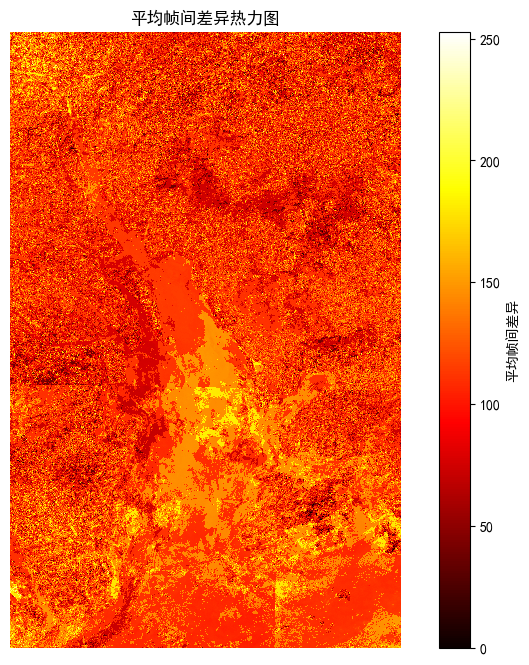

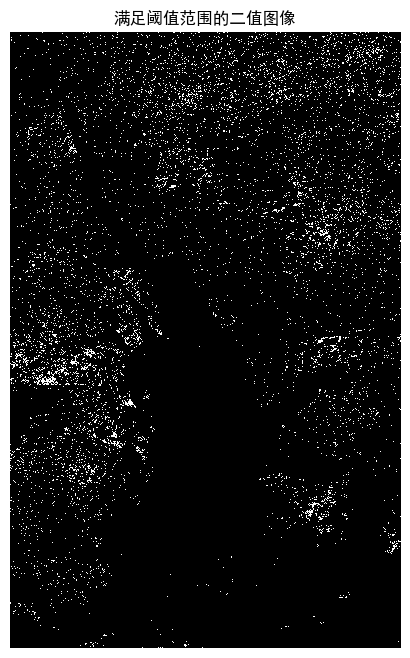

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image
from tqdm import tqdm
import os

# 设置字体为 SimHei（黑体）
matplotlib.rcParams['font.family'] = 'SimHei'
# 解决负号显示问题
matplotlib.rcParams['axes.unicode_minus'] = False

def generate_temporal_stability_heatmap(img_dir, threshold_min=0, threshold_max=np.inf):
    """
    生成时间稳定性热力图，并提取指定阈值范围内的平均差异位置信息。
    
    参数:
        img_dir (str): 图像文件夹路径
        threshold_min (float): 阈值范围的最小值，默认为 0
        threshold_max (float): 阈值范围的最大值，默认为无穷大
    """
    img_filenames = sorted([f for f in os.listdir(img_dir) if f.endswith('.png') or f.endswith('.jpg')])
    if not img_filenames:
        raise ValueError("指定目录中没有找到图像文件")
    
    imgs = []
    for img in tqdm(img_filenames, desc="加载图像"):
        img_path = os.path.join(img_dir, img)
        image = Image.open(img_path).convert('L')
        img_array = np.array(image)
        imgs.append(img_array)
    
    imgs = np.array(imgs)
    
    # 计算帧间差异
    diffs = np.diff(imgs, axis=0)
    
    # 计算每个像素点的平均帧间差异
    mae_map = np.mean(np.abs(diffs), axis=0)
    
    # 提取指定阈值范围内的位置信息
    thresholded_positions = np.argwhere((mae_map >= threshold_min) & (mae_map <= threshold_max))
    
    # 绘制热力图
    plt.figure(figsize=(10, 8))
    plt.imshow(mae_map, cmap='hot', interpolation='nearest')
    plt.colorbar(label='平均帧间差异')
    plt.title('平均帧间差异热力图')
    plt.axis('off')
    plt.show()
    
    return mae_map, thresholded_positions

def plot_thresholded_binary_image(thresholded_positions, img_shape):
    """
    绘制满足阈值范围的二值图像。
    
    参数:
        thresholded_positions (np.ndarray): 满足阈值范围的像素位置
        img_shape (tuple): 图像的形状 (高度, 宽度)
    """
    # 创建一个全零的二值图像
    binary_image = np.zeros(img_shape, dtype=np.uint8)
    
    # 将满足阈值范围的像素位置标记为255
    for pos in thresholded_positions:
        binary_image[pos[0], pos[1]] = 255
    
    # 绘制二值图像
    plt.figure(figsize=(10, 8))
    plt.imshow(binary_image, cmap='gray', interpolation='nearest')
    plt.title('满足阈值范围的二值图像')
    plt.axis('off')
    plt.show()

# 使用示例
image_dir = 'E:/lama/jet_S2_Daily_Mosaic/'
threshold_min = 0  # 设置阈值范围的最小值
threshold_max = 70  # 设置阈值范围的最大值
mae_map, thresholded_positions = generate_temporal_stability_heatmap(image_dir, threshold_min, threshold_max)

# 绘制满足阈值范围的二值图像
plot_thresholded_binary_image(thresholded_positions, mae_map.shape)

#### 指定阈值范围 & 指定路径下二值掩码

加载二值图像: 100%|██████████| 8/8 [00:00<00:00, 133.57it/s]


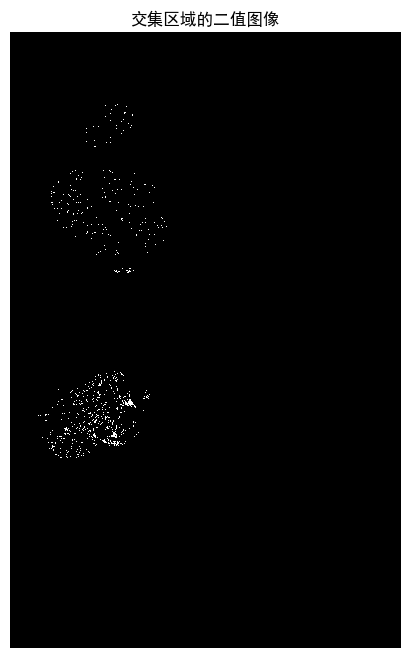

In [10]:
def load_binary_image(binary_image_dir):
    """
    加载指定路径的二值图像。
    
    参数:
        binary_image_path (str): 二值图像的路径
    """
    binary_image_path = sorted([os.path.join(binary_image_dir,f) for f in os.listdir(binary_image_dir) if f.endswith('.png') or f.endswith('.jpg')])
    if not binary_image_path:
        raise ValueError("指定目录中没有找到二值图像文件")
    binary_image_list = []
    for binary_image_path in tqdm(binary_image_path, desc="加载二值图像"):
        # 读取并转换为灰度图像
        binary_image = Image.open(binary_image_path).convert('L')
        binary_image = np.array(binary_image)
        binary_image_list.append(binary_image)
    binary_image_list = np.array(binary_image_list)
    return binary_image_list
def calculate_intersection(thresholded_positions, binary_image):
    """
    计算阈值范围位置与二值图像的交集区域。
    
    参数:
        thresholded_positions (np.ndarray): 满足阈值范围的像素位置
        binary_image (np.ndarray): 二值图像
    """
    # 创建一个与二值图像相同大小的全零数组
    thresholded_image = np.zeros_like(binary_image[0])
    
    # 将满足阈值范围的像素位置标记为255
    for pos in thresholded_positions:
        thresholded_image[pos[0], pos[1]] = 255
    
    # 计算交集区域
    intersection = (thresholded_image & binary_image) > 0
    
    return intersection

def plot_intersection(intersection, img_shape):
    """
    绘制交集区域的二值图像。
    
    参数:
        intersection (np.ndarray): 交集区域的布尔数组
        img_shape (tuple): 图像的形状 (高度, 宽度)
    """
    intersection_image = intersection.astype(np.uint8) * 255
    plt.figure(figsize=(10, 8))
    plt.imshow(intersection_image[0], cmap='gray', interpolation='nearest')
    plt.title('交集区域的二值图像')
    plt.axis('off')
    plt.show()
# 加载二值图像
binary_image = load_binary_image('E:/lama/mask_img/')

# 计算交集区域
intersection = calculate_intersection(thresholded_positions, binary_image)

# 绘制交集区域的二值图像
plot_intersection(intersection, binary_image.shape)

### 控制时序变化阈值对比不同算法的精度

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image
from tqdm import tqdm
import os

# 设置字体为 SimHei（黑体）
matplotlib.rcParams['font.family'] = 'SimHei'
# 解决负号显示问题
matplotlib.rcParams['axes.unicode_minus'] = False
#* 计算时序稳定（帧间差异）
def generate_temporal_stability_heatmap(img_dir, threshold_min, threshold_max):
    """
    生成时间稳定性热力图，并提取指定阈值范围内的平均差异位置信息。
    
    参数:
        img_dir (str): 图像文件夹路径
        threshold_min (float): 阈值范围的最小值，默认为 0
        threshold_max (float): 阈值范围的最大值，默认为无穷大
    """
    img_filenames = sorted([f for f in os.listdir(img_dir) if f.endswith('.png') or f.endswith('.jpg')])
    if not img_filenames:
        raise ValueError("指定目录中没有找到图像文件")
    
    imgs = []
    for img in tqdm(img_filenames, desc="加载图像"):
        img_path = os.path.join(img_dir, img)
        image = Image.open(img_path).convert('L')
        img_array = np.array(image)
        imgs.append(img_array)
    
    imgs = np.array(imgs)
    
    # 计算帧间差异
    diffs = np.diff(imgs, axis=0)
    
    # 计算每个像素点的平均帧间差异
    mae_map = np.mean(np.abs(diffs), axis=0)
    
    # 提取指定阈值范围内的位置信息
    thresholded_positions = np.argwhere((mae_map >= threshold_min) & (mae_map <= threshold_max))
    
    # 绘制热力图
    # plt.figure(figsize=(10, 8))
    # plt.imshow(mae_map, cmap='hot', interpolation='nearest')
    # plt.colorbar(label='平均帧间差异')
    # plt.title('平均帧间差异热力图')
    # plt.axis('off')
    # plt.show()
    
    return mae_map, thresholded_positions
#* 筛选满足阈值范围的二值图像
def plot_thresholded_binary_image(thresholded_positions, img_shape):
    """
    绘制满足阈值范围的二值图像。
    
    参数:
        thresholded_positions (np.ndarray): 满足阈值范围的像素位置
        img_shape (tuple): 图像的形状 (高度, 宽度)
    """
    # 创建一个全零的二值图像
    binary_image = np.zeros(img_shape, dtype=np.uint8)
    
    # 将满足阈值范围的像素位置标记为255
    for pos in thresholded_positions:
        binary_image[pos[0], pos[1]] = 255
    
    # 绘制二值图像
    plt.figure(figsize=(10, 8))
    plt.imshow(binary_image, cmap='gray', interpolation='nearest')
    plt.title('满足阈值范围的二值图像')
    plt.axis('off')
    plt.show()
#* 加载其他二值图像掩码
def load_image(binary_image_dir,img_type):
    """
    加载指定路径的二值图像。
    
    参数:
        binary_image_path (str): 二值图像的路径
    """
    binary_image_path = sorted([os.path.join(binary_image_dir,f) for f in os.listdir(binary_image_dir) if f.endswith('.png') or f.endswith('.jpg')])
    if not binary_image_path:
        raise ValueError("指定目录中没有找到二值图像文件")
    binary_image_list = []
    for binary_image_path in tqdm(binary_image_path, desc="加载二值图像"):
        # 读取并转换为灰度/RGB图像
        binary_image = Image.open(binary_image_path).convert(img_type)
        binary_image = np.array(binary_image)
        binary_image_list.append(binary_image)
    binary_image_list = np.array(binary_image_list)
    return binary_image_list
#* 计算阈值范围位置与二值图像的交集区域
def calculate_intersection(thresholded_positions, binary_image):
    """
    计算阈值范围位置与二值图像的交集区域。
    
    参数:
        thresholded_positions (np.ndarray): 满足阈值范围的像素位置
        binary_image (np.ndarray): 二值图像
    """
    # 创建一个与二值图像相同大小的全零数组
    thresholded_image = np.zeros_like(binary_image[0])
    
    # 将满足阈值范围的像素位置标记为255
    for pos in thresholded_positions:
        thresholded_image[pos[0], pos[1]] = 255
    
    # 计算交集区域
    intersection = (thresholded_image & binary_image) > 0
    
    return intersection
#* 计算pred和target差异
def calculate_image_difference(image1, image2, valid_positions):
    """
    根据布尔数组的 True 位置，计算两个影像数组间的差异，并计算多个衡量指标。
    
    参数:
        image1 (np.ndarray): 第一个影像数组
        image2 (np.ndarray): 第二个影像数组
        bool_array (np.ndarray): 布尔数组，形状与 image1 和 image2 相同
    
    返回:
        metrics (dict): 包含多个衡量指标的字典
    """
    if image1.shape[:2] != image2.shape[:2] or image1.shape[:2] != valid_positions.shape[:2]:
        raise ValueError("输入数组的形状必须相同")
    
    # 计算差异
    differences = image1[valid_positions] - image2[valid_positions]
    
    # 计算衡量指标
    metrics = {
        'mean_absolute_difference': np.mean(np.abs(differences)),  # 平均绝对差异
        'mean_squared_difference': np.mean(differences ** 2),     # 平均平方差异
        'standard_deviation': np.std(differences),                # 差异的标准差
        'max_difference': np.max(np.abs(differences)),            # 最大绝对差异
        'min_difference': np.min(np.abs(differences)),            # 最小绝对差异
        'median_difference': np.median(differences),              # 中位数差异
    }
    
    return metrics

image_dir = 'E:/lama/jet_S2_Daily_Mosaic/'
threshold_min = 0  # 设置阈值范围的最小值
threshold_max = 70  # 设置阈值范围的最大值
mae_map, thresholded_positions = generate_temporal_stability_heatmap(image_dir, threshold_min, threshold_max)
# 加载图像
binary_image = load_image('E:/lama/mask_img/','L')
image1 = load_image('E:/lama/jet_S2_Daily_Mosaic/', 'RGB')
image2 = load_image('E:/lama/inpainted_img/lama_init/', 'RGB')
# 计算交集区域
intersection = calculate_intersection(thresholded_positions, binary_image)
metrics = calculate_image_difference(image1, image2, intersection)
print("衡量指标：")
for key, value in metrics.items():
    print(f"{key}: {value}")

加载二值图像: 100%|██████████| 8/8 [00:00<00:00, 28.52it/s]


衡量指标：
mean_absolute_difference: 129.6869062299182
mean_squared_difference: 70.0382154911394
standard_deviation: 107.29120327123441
max_difference: 255
min_difference: 0
median_difference: 129.0
sum_absolute_difference: 22400949
sum_squared_difference: 12097771
